**Few-Shot Classification on LIVECell using DINOv3 Embeddings**



*   Lorenzo Salerno
*   Paolo Zimbardi



# Introduzione e Obiettivo

Nel contesto biomedico, l'approccio tradizionale basato sui "Big Data" incontra spesso un muro: la scarsità di dati etichettati. \
Per questo motivo, il progetto adotta il **Few-Shot Learning (FSL)**: un paradigma che non mira a memorizzare migliaia di immagini, ma a insegnare al modello a generalizzare partendo da pochissimi esempi (support set), simulando la capacità umana di apprendere visivamente in modo rapido.

A differenza dell'addestramento classico che elabora tutto il dataset ciclicamente (epoche), il Few-Shot Learning lavora per **episodi**.
Ogni episodio è composto da:

•Un **Support Set** (es. 5 immagini per classe) per definire i riferimenti.

•Un **Query Set** (immagini sconosciute) che il modello deve classificare basandosi sui riferimenti appena visti.

I dataset biologici reali sono fortemente sbilanciati (alcune cellule sono comunissime, altre rare). L'approccio a episodi risolve questo problema alla radice tramite la tecnica **N-way K-shot**:
in ogni episodio, forziamo il modello a vedere lo stesso numero di esempi ($K$) per ogni classe, questo fa si che all'interno dell'episodio, la classe rara ha la stessa importanza numerica di quella frequente.

Un'alternativa tradizionale per gestire lo sbilanciamento consiste nel ridimensionare le classi numerose (undersampling). Sebbene questo approccio velocizzi il training ed eviti che il modello si focalizzi eccessivamente sulle classi più frequenti, esso comporta inevitabilmente una perdita di informazioni. Con **DINOv3** e le **Prototypical Networks** questo sacrificio non è necessario visto che la struttura a episodi bilancia automaticamente le classi ogni volta che le presenta al modello. Questo ci permette di sfruttare l'intero dataset senza che le classi frequenti dominino su quelle rare.

Poiché l'obiettivo è l'affidabilità clinica su tutte le classi, valutiamo le performance utilizzando metriche **Macro** (come la Macro-F1), queste calcolano il punteggio per ogni singola classe e ne fanno la media. Questo assicura che un errore su una cellula rara penalizzi il punteggio tanto quanto un errore su una cellula comune, garantendo una diagnosi affidabile.

## Librerie utilizzate

In [ ]:
import os
import random
import zipfile
from glob import glob

import torch
from torch.utils.data import Dataset, DataLoader,IterableDataset, get_worker_info
import torch.nn as nn
import torch.nn.functional as F

import pandas as pd
import matplotlib.pyplot as plt
import numpy as np

from PIL import Image

from tqdm import tqdm
from tqdm.auto import tqdm as tqdm_auto
import shutil

from google.colab import drive, userdata

from huggingface_hub import login
from transformers import AutoImageProcessor, AutoModel

import plotly.express as px
import umap


# Dataset e Exploratory Data Analysis

In questa fase viene estratto ed esplorato il dataset da utilizzare per il progetto.
L'obiettivo principale è quello di comprendere la struttura dei dati, l'organizzazione delle classi e il formato delle immagini riuscendo così a garantire una corretta impostazione delle fasi successive.

## Estrazione dei dati

In [ ]:
drive.mount('/content/drive', force_remount=True)
os.listdir('/content/drive/MyDrive')

zip_path = "/content/drive/MyDrive/livecell.zip"
extract_path = "/content/livecell"
os.makedirs(extract_path, exist_ok=True)

with zipfile.ZipFile(zip_path, "r") as z:
    files = z.namelist()
    for f in tqdm(files, desc="Unzip del dataset LIVECell"):
        z.extract(f, extract_path)



Mounted at /content/drive


Unzip del dataset LIVECell: 100%|██████████| 1650021/1650021 [02:18<00:00, 11898.98it/s]


Per velocizzare le operazioni dati sono stati estratti nella cartella temporanea  content di colab, quest'operazione impiega circa 4 minuti.
Se avessimo voluto estrarre le immagini sul drive avremmo avuto tempi di attesa per l'esecuzione elevati.

In [ ]:
print(os.listdir("/content/livecell/livecell")[:20])


['BT474_dataset.csv', 'SKOV3_dataset_val.csv', 'BV2_dataset.csv', 'SKOV3_dataset.csv', 'Huh7_dataset.csv', 'train', 'test', 'MCF7_dataset_test.csv', 'SkBr3_dataset.csv', 'SKOV3_dataset_test.csv', 'A172_dataset_val.csv', 'BV2_dataset_test.csv', 'A172_dataset_test.csv', 'BT474_dataset_test.csv', 'SHSY5Y_dataset_val.csv', 'SkBr3_dataset_val.csv', 'Huh7_dataset_test.csv', 'MCF7_dataset.csv', 'val', 'BV2_dataset_val.csv']


Da qui notiamo la presenza di 8 classi distinte, il dataset è composto da immagini associate ad etichette di classe e, come vediamo dal chunk precedente, organizzato in partizioni distinte (train, validation e test).

Andiamo adesso a preparare il dataset per le successive fasi di analisi esplorativa

In [ ]:
BASE_PATH = "/content/livecell/livecell"

records = []

for f in os.listdir(BASE_PATH):
    if f.endswith("_dataset.csv") and "_val" not in f and "_test" not in f:
        cell_type = f.replace("_dataset.csv", "")
        df = pd.read_csv(os.path.join(BASE_PATH, f))
        records.append({
            "cell_type": cell_type,
            "split": "all",
            "num_images": len(df)
        })

eda_df = pd.DataFrame(records).sort_values("num_images", ascending=False)


L’analisi esplorativa dei dati ha lo scopo di fornire una visione preliminare delle caratteristiche principali del dataset, individuando eventuali criticità e pattern rilevanti prima dell’estrazione delle feature.

Queste analisi permettono di verificare la coerenza del dataset e di individuare possibili squilibri o anomalie che potrebbero influenzare le prestazioni dei modelli.

## Distribuzione delle immagini

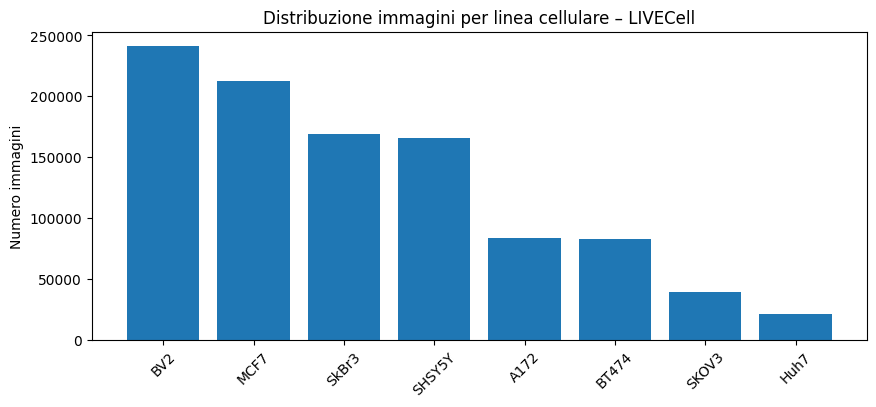

In [ ]:
plt.figure(figsize=(10,4))
plt.bar(eda_df["cell_type"], eda_df["num_images"])
plt.xticks(rotation=45)
plt.ylabel("Numero immagini")
plt.title("Distribuzione immagini per linea cellulare – LIVECell")
plt.show()


La figura mostra la distribuzione del numero di immagini per ciascuna linea cellulare nel dataset LiveCell.
Osserviamo che la distribuzione delle immagini nelle classi è eterogenea, abbiamo classi, quali BV2 e MCF7, che presentano un numero molto elevato di campioni mentre altre, come SKOV3 e Huh7, che risultano significativamente meno rappresentate.


Questa distribuzione non uniforme evidenzia un notevole sbilanciamento tra le classi, questa caratteristica è particolarmente interessante nel contesto _few-shot learning_ poichè la presenza di esempi limitati potrebbe influenzare la prestazione dei modelli ma, tuttavia, questa variabilità rende particolarmente adatto il dataset a valutare la capacità di generalizzazione delle rappresentazioni visive estratte.

## Esempi di cellule nel dataset

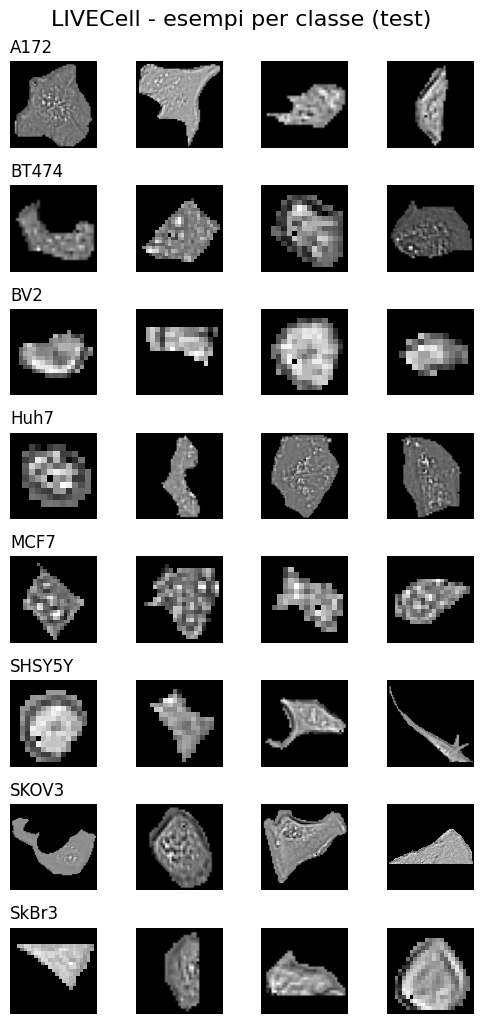

In [ ]:
BASE = "/content/livecell/livecell"
SPLIT = "test"
ROOT = os.path.join(BASE, SPLIT)

classes = sorted([d for d in os.listdir(ROOT) if os.path.isdir(os.path.join(ROOT, d))])
n_per_class = 4

fig, axes = plt.subplots(len(classes), n_per_class, figsize=(n_per_class*1.3, len(classes)*1.3))

for i, cls in enumerate(classes):
    cls_dir = os.path.join(ROOT, cls)
    imgs = [f for f in os.listdir(cls_dir) if f.lower().endswith((".png", ".jpg", ".jpeg", ".tif", ".tiff"))]
    if len(imgs) == 0:
        continue

    picks = random.sample(imgs, k=min(n_per_class, len(imgs)))

    for j in range(n_per_class):
        ax = axes[i, j] if len(classes) > 1 else axes[j]
        ax.axis("off")
        if j < len(picks):
            img_path = os.path.join(cls_dir, picks[j])
            img = Image.open(img_path)
            ax.imshow(img, cmap="gray" if img.mode in ("L", "I;16") else None)
        if j == 0:
            ax.set_title(cls, loc="left", fontsize=12)

plt.suptitle(f"LIVECell - esempi per classe ({SPLIT})", fontsize=16)
plt.tight_layout()
plt.show()


La figura mostra alcuni esempi rappresentativi di immagini per ciascuna linea cellulare prese dalla partizione del test set.
Le immagini evidenziano una notevole variabilità morfologica tra le diverse classi, sia in termini di forma cellulare che di densità e organizzazione.
Questa eterogeneità va a sottolineare la complessità del task di classificazione e giustifica l'utilizzo di rappresentazioni visive robuste così da poter catturare caratteristiche semantiche discriminative che ci permettano la corretta classificazione.

## Controllo Train Test e Val

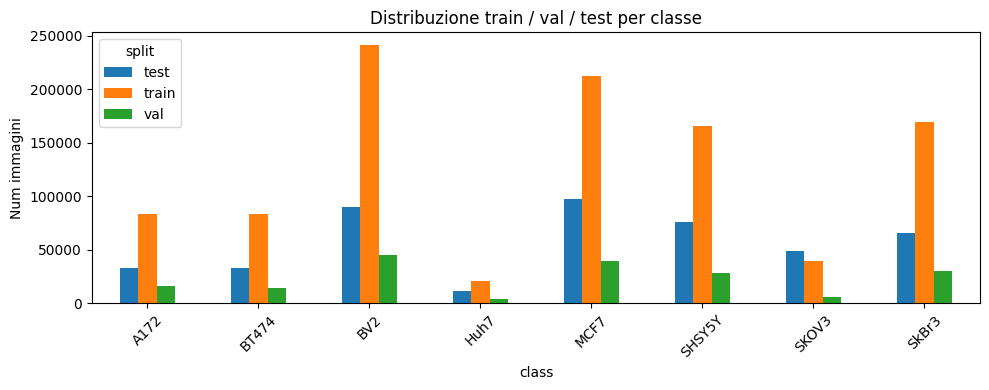

In [ ]:
BASE = "/content/livecell/livecell"

def count_split(split):
    root = os.path.join(BASE, split)
    rows = []
    for cls in os.listdir(root):
        cls_dir = os.path.join(root, cls)
        if os.path.isdir(cls_dir):
            n = len(os.listdir(cls_dir))
            rows.append((cls, split, n))
    return rows

rows = []
for split in ["train", "val", "test"]:
    rows += count_split(split)

df = pd.DataFrame(rows, columns=["class", "split", "count"])

df_pivot = df.pivot(index="class", columns="split", values="count")
df_pivot.plot(kind="bar", figsize=(10,4))
plt.ylabel("Num immagini")
plt.title("Distribuzione train / val / test per classe")
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()


Questo grafico rappresenta la distribuzione del numero di immagini per ciascuna classe nelle tre partizioni del dataset.
Osserviamo, come potevamo già aspettarci dai risultati della distribuzione di prima, una marcata differenza nelle numerosità dei campioni tra le classi.
Andiamo quindi a confermare ciò che avevamo detto prima riguardo lo sbilanciamento intrinseco del dataset.

## Boxplot per classe

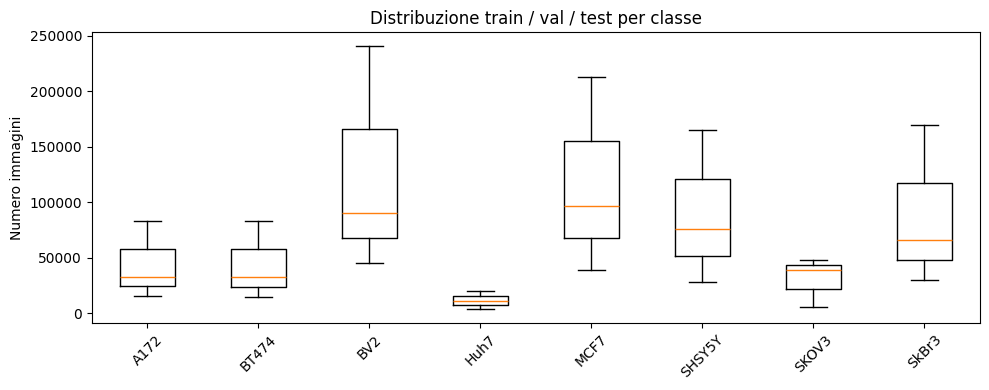

In [ ]:
plt.figure(figsize=(10,4))

data = [df_pivot.loc[cls].dropna().values for cls in df_pivot.index]

plt.boxplot(
    data,
    tick_labels=df_pivot.index
)

plt.ylabel("Numero immagini")
plt.title("Distribuzione train / val / test per classe")
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()



Il boxplot riassume la distribuzione del numero di immagini per ciascuna classe considerando i tre split del dataset.
La differenza tra i valori evidenzia una marcata variabilità nella numerosità dei campioni, con una predominanza sistematica del training set rispetto agli altri split.

## Confronto qualitativo

Oltre all'analisi quantitativa, è utile affiancare un confronto qualitativo tra le diversi classe nel dataset.
Questa analisi visiva consente di osservare direttamente le differenze morfologiche tra le linee cellulari evidenziando come alcune classi risultino facilmente distinguibili mentre altre presentino caratteristiche molto simili.
In particolare, la presenza di strutture cellulari analoghe, densità comparabili o forme sovrapponibili può rendere più complesso il processo di classificazione, soprattutto in scenari few-shot in cui il numero di esempi disponibili è limitato.

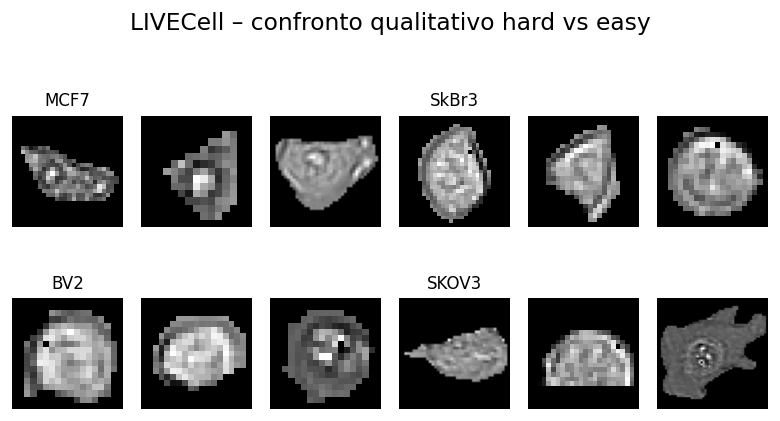

In [ ]:
BASE = "/content/livecell/livecell"
SPLIT = "test"
ROOT = os.path.join(BASE, SPLIT)

hard_classes = ["MCF7", "SkBr3"]
easy_classes = ["BV2", "SKOV3"]

classes = hard_classes + easy_classes
n_per_class = 3

fig, axes = plt.subplots(
    2, n_per_class * 2,
    figsize=(n_per_class * 2.2, 4),
    dpi=120
)

for row, cls_group in enumerate([hard_classes, easy_classes]):
    for i, cls in enumerate(cls_group):
        cls_dir = os.path.join(ROOT, cls)
        imgs = [f for f in os.listdir(cls_dir) if f.lower().endswith((".png", ".jpg", ".jpeg", ".tif", ".tiff"))]
        picks = random.sample(imgs, n_per_class)

        for j, img_name in enumerate(picks):
            ax = axes[row, i * n_per_class + j]
            img = Image.open(os.path.join(cls_dir, img_name))
            ax.imshow(img, cmap="gray" if img.mode in ("L", "I;16") else None)
            ax.axis("off")
            if j == 0:
                ax.set_title(cls, fontsize=10)


axes[0, 0].set_ylabel("Hard (classi simili)", fontsize=11)
axes[1, 0].set_ylabel("Easy (classi diverse)", fontsize=11)

plt.suptitle("LIVECell – confronto qualitativo hard vs easy", fontsize=14)
plt.tight_layout()
plt.show()



Questa figura va quindi a mostrare un confronto qualitativo tra alcune linee cellulari del dataset mettendo in evidenza esempi di classi visivamente più semplici da distinguere e classi che presentano caratteristiche morfologiche simili.
In particolare alcune linee cellulari mostrano pattern distintivi in termini di forma e struttura mentre altre risultano più difficili da separare a causa di geometrie e texture comparabil.

Questa rappresentazione ci fa capire che il problema non è solo la mancanza di esempi per determinate classi ma anche dal grado di similarità visiva tra esse.
Di conseguenza l'utilizzo di rappresentazioni visive robuste diventa cruciale per catturare differenze sottili tra classi simili, specialmente in ottica few-shot.

## Dimensione Immagini

L’analisi delle dimensioni delle immagini rappresenta un passaggio preliminare utile per comprendere la struttura del dataset.
Sebbene le immagini vengano successivamente standardizzate durante la fase di feature extraction con DINOv3, eventuali differenze nella risoluzione originale possono fornire indicazioni sulla coerenza dei dati e sull’assenza di anomalie prima del preprocessing.

### Plot su dimensione immagini

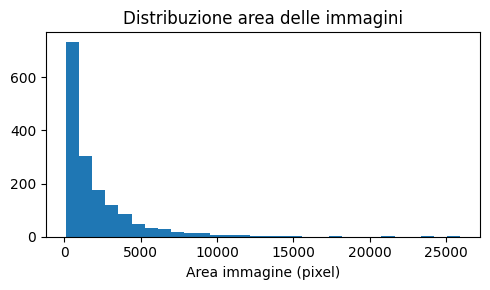

In [ ]:
BASE = "/content/livecell/livecell/train"

areas = []
classes = []

for cls in os.listdir(BASE):
    cls_dir = os.path.join(BASE, cls)
    for f in os.listdir(cls_dir)[:200]:
        img = Image.open(os.path.join(cls_dir, f))
        w, h = img.size
        areas.append(w * h)
        classes.append(cls)

plt.figure(figsize=(5,3))
plt.hist(areas, bins=30)
plt.xlabel("Area immagine (pixel)")
plt.title("Distribuzione area delle immagini")
plt.tight_layout()
plt.show()



La figura mostra la distribuzione dell'area delle immagini nel dataset calcolata come prodotto tra larghezza e altezza in pixel.
Si osserva una distribuzione fortemente asimmetrica caratterizzata da un'elevata concentrazione di immagini di piccole dimensioni e da un numero ridotto di immagini con area significativamente maggiore.
Ad ogni modo le differenze verranno poi mitigate dalla successiva standardizzazione dell'input prevista da **DINOv3**


# Feature extraction / Embeddings (DINOv3)

Per comprendere la potenza del modello utilizzato in questo progetto, è necessario fare un passo indietro e analizzare il cambio di paradigma introdotto da Meta AI con la famiglia di modelli DINO.

Tradizionalmente, per addestrare una rete neurale servivano milioni di immagini etichettate manualmente. Questo approccio, detto Supervisionato, è limitante in ambiti come la biologia cellulare, dove le etichette sono costose e rare.  
La rivoluzione arriva con il **Self-Supervised Learning (SSL)**: l'idea è che la rete possa imparare a "vedere" e capire le strutture delle immagini semplicemente osservandone milioni, senza alcuna etichetta.

## **DINOv3**
Il primo modello, DINO, introdotto nel 2021, ha introdotto l'idea pionieristica secondo cui le reti neurali potessero apprendere rappresentazioni significative attraverso l'auto-distillazione, ovvero osservando le immagini senza alcuna etichetta o intervento umano. Successivamente, nel 2023, DINOv2 ha scalato questo approccio, migliorando la stabilità dell'addestramento e dimostrando per la prima volta che le caratteristiche estratte (features) potevano essere trasferite efficacemente tra domini completamente diversi, dalla medicina all'analisi satellitare, senza la necessità di un riaddestramento specifico (fine-tuning).
Nell'agosto 2025, Meta AI ha rilasciato **DINOv3**, portando questa tecnologia a un livello senza precedenti. Con **7 miliardi di parametri** e addestrato su **1.7 miliardi di immagini**, DINOv3 non è solo un modello più grande, ma uno strumento radicalmente più preciso. Il suo punto di forza risiede nella risoluzione del problema del **dense feature degradation** (degrado delle caratteristiche dense), grazie a un'architettura che forza il mantenimento dei dettagli ad alta frequenza tramite una tecnica chiamata **Gram Anchoring**. I modelli precedenti, infatti, tendevano a "sfocare" matematicamente i dettagli più minuti quando analizzavano immagini complesse. Per l'analisi cellulare questo era un limite critico: distinguere una cellula sana da una malata dipende spesso da micro-dettagli come la rugosità della membrana o piccoli granuli nel citoplasma.

In questo progetto, utilizziamo DINOv3 come un **Universal Vision Encoder** in modalità **Frozen** (congelata). Invece di ri-addestrarlo da zero, rischiando di compromettere le sue conoscenze universali, lo sfruttiamo come un **Feature Extractor**. Il modello osserva l'immagine microscopica, ne comprende profondità e geometria, ed estrae una firma matematica (vettore embedding) estremamente ricca. Questa rappresentazione viene poi utilizzata dal nostro sistema di classificazione per distinguere le cellule con pochissimi esempi a disposizione, abilitando con successo il paradigma del Few-Shot Learning.

## Login Hugging Face e import DINOv3

Per poter utilizzare il modello dobbiamo importarlo da hugging face, iniziamo con il login

In [ ]:
f=userdata.get('loginhugging')
login(f)


Procediamo adesso all'upload del modello

In [ ]:
model_id = "facebook/dinov3-vits16-pretrain-lvd1689m"
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
processor = AutoImageProcessor.from_pretrained(model_id)
model = AutoModel.from_pretrained(model_id).to(device)
model.eval()
for p in model.parameters():
    p.requires_grad = False

/usr/local/lib/python3.12/dist-packages/huggingface_hub/utils/_auth.py:94: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


preprocessor_config.json:   0%|          | 0.00/585 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/743 [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/86.4M [00:00<?, ?B/s]

Sebbene l'architettura completa di DINOv3 scali fino a 7 miliardi di parametri, in questo progetto utilizziamo la variante ViT-Small (ViT-S/16). Questa configurazione conta circa 21 milioni di parametri e produce vettori di embedding (le rappresentazioni compatte delle immagini) di dimensione 384.

Tale scelta è stata dettata dalla necessità di garantire la massima efficienza computazionale: un vettore a 384 dimensioni offre una densità informativa eccellente per catturare le variazioni morfologiche cellulari, evitando al contempo l'enorme carico computazionale dei modelli Giant.

Nel codice con `device` andiamo a selezionare la GPU ove fosse disponibile mentre con `processor` andiamo a definire la pipeline di preprocessing coerente con quella usata durante il pretraining del modello DINOv3 ovvero conversione dei canali ridimensionamento/crop alla risoluzione attesa dal modello, normalizzazione dei valori dei pixel e trasformazione dell'immagine in tensore.
`model` ci da il backbone e con `.eval()` andiamo a disattivare il dropout ovvero lo portiamo ad un comportamento deterministico, qui inoltre andiamo anche a disattivare i gradienti con `requires_grad=False`.


In questa fase stiamo andando quindi a impostare DINOv3 come **feature extractor frozen**.

## Preparazione Dati per l'estrazione di embedding con DINOv3

Prima di applicare DINOv3 come feature extractor è necessario organizzare il dataset in una forma strutturata che ci consenta di etichettare ogni immagine al proprio path, alla propria etichetta e allo split di appartenenza.
In questa fase andiamo inizialmente a caricare e unificare i file del dataset ottenendo così tre tabelle che fungono da riferimento per le successive fasi di caricamento delle immagini e di estrazione degli embedding.

In [ ]:
BASE = "/content/livecell/livecell"

def load_split(pattern):
    dfs = []
    for csv in sorted(glob(os.path.join(BASE, pattern))):
        dfs.append(pd.read_csv(csv, sep=None, engine="python"))
    return pd.concat(dfs, ignore_index=True)

df_train = load_split("*_dataset.csv")
df_val   = load_split("*_dataset_val.csv")
df_test  = load_split("*_dataset_test.csv")

print("Train:", len(df_train), "Validation:", len(df_val), "Test:", len(df_test))
print(df_train.columns)
print(df_train.head(3))


Train: 1014369 Validation: 181554 Test: 454075
Index(['filename', 'y_col'], dtype='object')
                                            filename y_col
0  /media/neurone-pc13/7FD0B7F50A4D7BEE/Pierpaolo...  A172
1  /media/neurone-pc13/7FD0B7F50A4D7BEE/Pierpaolo...  A172
2  /media/neurone-pc13/7FD0B7F50A4D7BEE/Pierpaolo...  A172


### Modifica colonna `filename`

I file caricati contengono nella colonna filename dei percorsi assoluti riferiti all'ambiente in cui sono stati scaricati. Dopo l'estrazione in Colab le immagini si trovano quindi in un percorso assoluto diverso da quello esplicitato nella colonna filename avendo una directory diversa.
Per rendere i Dataframe utilizzabili nella pipeline di caricamento immagini e nella fase di feature extraction andiamo a rimappare la colonna `filename` in modo che punti ai file realmente presenti nel filesystem corrente.

In [ ]:
ROOT = "/content/livecell/livecell"

def remap_one(old_path, label):
    old_path = str(old_path)
    label = str(label)

    if "/train/" in old_path:
        split = "train"
    elif "/val/" in old_path:
        split = "val"
    elif "/test/" in old_path:
        split = "test"
    else:
        raise ValueError(f"Non trovo train/val/test in: {old_path}")

    fname = os.path.basename(old_path)
    return os.path.join(ROOT, split, label, fname)

def remap_df(df):
    df = df.copy()
    df["filename"] = [remap_one(p, lab) for p, lab in zip(df["filename"], df["y_col"])]
    return df

df_train = remap_df(df_train)
df_val   = remap_df(df_val)
df_test  = remap_df(df_test)

print("Esempio nuovo path:", df_train["filename"].iloc[0])


Esempio nuovo path: /content/livecell/livecell/train/A172/A172_Phase_A7_2_02d08h00m_4.tif_c_241_.png


`ROOT` rappresenta la base del path nell'ambiente corrente Colab, tutti i path validi devono partire da qui.
La funzione `remap_one` prende in input il vecchio path e la label e restituisce un path nuovo e valido, inizia ad identificare all'interno dell'`old_path` lo split e, ove non dovesse appartenere a nessuno dei 3 split, restituirebbe un errore.
Viene successivamente estratto il nome del file il `fname` e mediante il comando `os.path.join` andiamo ad unire la base (`ROOT`) con lo `split`, la `label` e l'`fname`.

La funzione `remap_df` ci permette di applicare la funzione `remap_one` a tutto il dataset.


Dopo aver rimappato i percorsi delle immagini andiamo ad analizzare la distribuzione delle classi nei tre split del dataset.
In particolare andiamo a contare il numero di immagini per ciascuna linea cellulare, al fine di verificare il grado di sbilanciamento del dataset e la coerenza della grandezza degli split prima di procedere con la fase di estrazione delle features.

In [ ]:
counts_train = df_train["y_col"].value_counts()
counts_val   = df_val["y_col"].value_counts()
counts_test  = df_test["y_col"].value_counts()

summary = pd.DataFrame({
    "train": counts_train,
    "val": counts_val,
    "test": counts_test
}).fillna(0).astype(int)

print(summary.head(10))


         train    val   test
y_col                       
A172     83175  15688  32978
BT474    82900  14526  32585
BV2     241025  45033  89970
Huh7     20656   3632  11587
MCF7    212688  39252  96914
SHSY5Y  165397  28199  75988
SKOV3    39162   5531  48296
SkBr3   169366  29693  65757


### Verifica dei percorsi e rimozione delle immagini mancanti

Dopo la rimappatura dei percorsi andiamo ad eseguire un controllo di integrità per verificare che tutti i file che sono indicati nella colonna `filename` esistano.
Andiamo a fare quindi per ciascun split l'esistenza del path mediante il comando `os.path.exists`.

Le immagini mancanti verranno poi rimosse dal dataset per garantire una pipeline di caricamento robusta e per prevenire errori durante l'estrazione degli embedding con DINOV3.

### Train set

In [ ]:
missing_idx = []
missing_paths = []

for i, p in enumerate(tqdm(df_train["filename"], desc="Controllo dei file mancanti (train)")):
    if not os.path.exists(p):
        missing_idx.append(i)
        missing_paths.append(p)

print("Totale train:", len(df_train))
print("File mancanti:", len(missing_idx))
print("Percentuale:", 100 * len(missing_idx) / len(df_train), "%")


Controllo dei file mancanti (train): 100%|██████████| 1014369/1014369 [00:03<00:00, 271933.03it/s]

Totale train: 1014369
File mancanti: 1
Percentuale: 9.858345434452354e-05 %


Notiamo la presenza di un path mancante, dato il numero estremamente ridotto anche in percentuale sul totale delle immagini la rimozione non ha impatto statistico sulle analisi successive,

In [ ]:
df_train.loc[~df_train["filename"].map(os.path.exists), "filename"] = np.nan
df_train = df_train.dropna(subset=["filename"]).reset_index(drop=True)


### Test Set

In [ ]:
missing_idx = []
missing_paths = []

for i, p in enumerate(tqdm(df_test["filename"], desc="Controllo dei file mancanti (test)")):
    if not os.path.exists(p):
        missing_idx.append(i)
        missing_paths.append(p)

print("Totale train:", len(df_test))
print("File mancanti:", len(missing_idx))
print("Percentuale:", 100 * len(missing_idx) / len(df_test), "%")


Controllo dei file mancanti (test): 100%|██████████| 454075/454075 [00:03<00:00, 121637.22it/s]

Totale train: 454075
File mancanti: 0
Percentuale: 0.0 %


### Validation Set

In [ ]:
missing_idx = []
missing_paths = []

for i, p in enumerate(tqdm(df_val["filename"], desc="Controllo dei file mancanti (validation)")):
    if not os.path.exists(p):
        missing_idx.append(i)
        missing_paths.append(p)

print("Totale train:", len(df_val))
print("File mancanti:", len(missing_idx))
print("Percentuale:", 100 * len(missing_idx) / len(df_val), "%")


Controllo dei file mancanti (validation): 100%|██████████| 181554/181554 [00:00<00:00, 243390.34it/s]

Totale train: 181554
File mancanti: 0
Percentuale: 0.0 %


## Mappatura delle etichette

Le etichette originali del dataset LIVEcell sono rappresentate come stringhe testuali. Per rendere le utichette utilizzabili nelle successive fasi andiamo a costruire una mappatura tra ciascuna classe e un identificatore numerico intero.

In [ ]:

classes = sorted(df_train["y_col"].unique().tolist())
class_to_id = {c:i for i,c in enumerate(classes)}

for df in (df_train, df_val, df_test):
    df["label_id"] = df["y_col"].map(class_to_id).astype(np.int32)

print("Num classes:", len(classes))
print("Esempio mapping:", list(class_to_id.items()))

Num classes: 8
Esempio mapping: [('A172', 0), ('BT474', 1), ('BV2', 2), ('Huh7', 3), ('MCF7', 4), ('SHSY5Y', 5), ('SKOV3', 6), ('SkBr3', 7)]


`classes`  ci fa estrarre l'insieme delle classi presenti nel training set, ogni elemento è una linea cellulare distinsta e l'ordinamento con sorted rende il processo deterministico e riproducibile, classes rappresenta quindi una definizione dello spazio delle classi del problema.
Lo usiamo soltanto sul training set in quanto definisce il modello quali classi conosce e il test set e il validation set servono solo a valutare.
Con `class_to_id` andiamo ad assegnare ad ogni classe un indice nello spazio delle classi, questi indici saranno usanti per indicizzare i prototipi, per i confronti e per metriche e matrici.

Mediante il ciclo `for` andiamo a creare uan nuova colonna al dataset, `label_id` che otterremo grazie al comando `map` su ogni elemento del dataset guardando la `y_col`.
Andiamo ad usare come tipo `np.int32` perchè è compatibile con numpy, pytorch, è efficiente in memoria ed è più che sufficiente per 8 classi.

## Verifica funzionamento processor

Prima di procedere all'estrazione delle feature, è necessario trasformare le immagini grezze in un formato matematico compatibile con l'architettura del modello. In ambito Deep Learning, e specificamente nell'ecosistema Hugging Face, questo compito è affidato al Processor.

Le reti neurali profonde come DINOv3 non sono in grado di elaborare direttamente file immagine (JPEG, PNG). Esse richiedono in input **tensori** (matrici multidimensionali di numeri) che rispettino rigorosi vincoli di forma e statistica. L'AutoImageProcessor agisce come un "ponte standardizzato": garantisce che ogni singola immagine del dataset LIVECell subisca esattamente le stesse trasformazioni.

Di seguito, eseguiamo una verifica preliminare (sanity check) su un singolo campione. Questo passaggio serve a validare visivamente e tecnicamente che il processore carichi, ridimensioni e normalizzi correttamente le immagini prima di applicare la procedura all'intero dataset.

Andiamo quindi a recuperare il percorso del primo file dal DataFrame di validazione. L'immagine viene caricata e contestualmente convertita in formato RGB (3 canali). Questa conversione è essenziale: indipendentemente dal formato originale (es. scala di grigi), il modello DINOv3 richiede tassativamente un input a tre canali per poter elaborare il tensore.

In [ ]:
p = df_val.iloc[0]["filename"]
img = Image.open(p).convert("RGB")

Il processor converte l'immagine in un formato numerico (tensore PyTorch). Poiché il modello si aspetta sempre di ricevere una batch di immagini, l'output iniziale ha una dimensione extra. Con il comando `[0]`, estraiamo la singola immagine dal lotto per poterla analizzare singolarmente.

In [ ]:
inputs = processor(images=img, return_tensors="pt")
pv = inputs["pixel_values"][0].cpu()

Per visualizzare correttamente il tensore processato, è necessario invertire la normalizzazione applicata dal modello.

In [ ]:
mean = torch.tensor(processor.image_mean).view(3,1,1)
std  = torch.tensor(processor.image_std).view(3,1,1)
x = pv * std + mean
x = x.clamp(0, 1)
x = x.permute(1, 2, 0).numpy()

Recuperiamo le statistiche matematiche (media e deviazione standard) usate in precedenza e le applichiamo al contrario per ripristinare i colori originali dei pixel. Durante questo calcolo, il comando `clamp` serve a "ripulire" i dati, forzando tutti i valori a restare entro i limiti corretti (tra 0 e 1) per evitare difetti visivi dovuti a piccoli errori di calcolo. Infine, l'istruzione `permute` riorganizza la struttura dei dati: sposta le informazioni sul colore (i canali) in ultima posizione, rendendo il formato compatibile con gli strumenti standard di visualizzazione

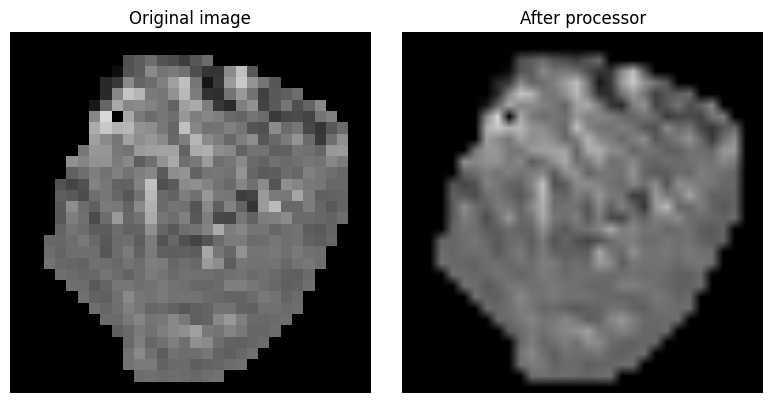

In [ ]:
fig, axs = plt.subplots(1, 2, figsize=(8,4))

axs[0].imshow(img)
axs[0].set_title("Original image")
axs[0].axis("off")

axs[1].imshow(x)
axs[1].set_title("After processor")
axs[1].axis("off")

plt.tight_layout()
plt.show()


Per concludere la verifica, il codice genera un layout grafico composto da due pannelli affiancati tramite la funzione `subplots`. Nel primo pannello viene visualizzata l'immagine originale caricata da disco, mentre nel secondo viene mostrato il risultato della ricostruzione ottenuta dal tensore (x). Per entrambe le figure, utilizziamo il comando `imshow` per il rendering dei pixel e `axis("off")` per rimuovere assi e bordi numerici, che risulterebbero superflui in un'analisi puramente qualitativa. Infine, `tight_layout` ottimizza automaticamente gli spazi bianchi tra i due grafici per evitare sovrapposizioni.

Il test conferma che le trasformazioni geometriche e cromatiche non introducono distorsioni semantiche, validando l'uso del processor per l'intera fase di estrazione delle feature.

## Dataset e DataLoader

In questa fase andiamo a definire la pipeline di caricamento dei dati che collega la rappresentazione tabellare alle operazioni di estrazione delle feature con DINOv3.
A partire dai dataframe contenenti i percorsi delle immagini e delle etichette numeriche viene implementata una classe `Dataset` personalizzata che si occupa di aprire le immagini, applicare il preprocessing coerente con DINOv3 e restituire i tensori di input associati alla relativa etichetta.

Successivamente i DataLoader Pytorch vengono utilizzati anche per iterare in modo efficiente sul dataset consentendo così l'elaborazione batch delle immagini e l'estrazione degli embedding su larga scala.

In [ ]:
class DinoDFDataset(Dataset):
    def __init__(self, df, processor):
        self.df = df.reset_index(drop=True)
        self.processor = processor

    def __len__(self):
        return len(self.df)

    def __getitem__(self, idx):
        row = self.df.iloc[idx]
        path = row["filename"]
        y = int(row["label_id"])

        img = Image.open(path)
        if img.mode != "RGB":
            img = img.convert("RGB")

        enc = self.processor(images=img, return_tensors="pt")
        pixel_values = enc["pixel_values"].squeeze(0)
        return pixel_values, y

def make_loader(df, processor, batch_size=64, num_workers=8):
    ds = DinoDFDataset(df, processor)

    kwargs = dict(
        batch_size=batch_size,
        shuffle=False,
        num_workers=num_workers,
        pin_memory=True,
    )
    if num_workers > 0:
        kwargs["persistent_workers"] = True
        kwargs["prefetch_factor"] = 2

    return DataLoader(ds, **kwargs)

train_loader = make_loader(df_train, processor, batch_size=64, num_workers=8)
val_loader   = make_loader(df_val,   processor, batch_size=64, num_workers=8)
test_loader  = make_loader(df_test,  processor, batch_size=64, num_workers=8)

x, y = next(iter(val_loader))
print("Batch:", x.shape, y.shape)


Batch: torch.Size([64, 3, 224, 224]) torch.Size([64])


La classe `DinoDFDataset` prenderà in input `df` ovvero il dataframe con almeno filename e label_id  e `proessor` ovvero l'AutoImageProcessor di DINOv3.
Con `reset_index(drop=True)` andiamo a rendere l'indice continuo evitando problemi nel caso in cui siano state filtrate le righe.
Con il magit method `len` andiamo a vedere il numero di campioni nel dataset, `getitem` invece che riceve in input l'indice ci permette di estrarre la riga, il path e la y per aprire correttamente l'immagine che ci interessava.
Le immagini che vengono aperte vengono convertire in RGB poichè è ciò che si aspetta DINOv3, lo facciamo preventivamente per evitare errori e rendere l'input consistente.
`enc` va a richiamare il processor che applica automaticamente le stesse operazioni usate quando DINOv3 è stato addestrato e il risultato è che in enc troveremo un dizionario python con all'interno pixel_vales ovvero un tensore di grandezza, ad esempio, (1, 3, 224, 224) dove 1 è la batch size, 3 sono i canali RGB mentre 224 indica sia l'altezza che la larghezza.
Con `squeeze(0)` andiamo a rimuovere la dimensione batch e restituiamo un singolo campione.
`enc` è quindi solo il contenitore dell’input preprocessato; il tensore reale che entra in DINOv3 è `enc["pixel_values"]`.


La funzione `make_loader` prende in input il daframe, processor, `batch_size` ovvero il numero di immagini per batch e `num_workers` ovvero il numero di processi paralleli che caricano le immagini, ogni worker è un processo separato, esegue il getitem del dataset servono quindi per la fase di I/O  e preprocessing.
Essendo il dataset enorme se non mettessimo i worker la GPU dovrebbe aspettare il disco in questo modo la GPU lavora continuamente, li poniamo ad 8 perchè mettere un numero troppo alto potrebbe portare problemi come competizione su disco, overhead di creazione dei processi, sostanzialmente mediante `num_workers` andiamo ad evitare che la GPU aspetti il caricamento dei dati.
Con `ds` andiamo a creare il dataset, in questo modo grazie al getitem della classe possiamo anche andare ad aprire le immagini, successivamente nel `kwargs` andiamo a creare un dizionario con batch_size, `shuffle=False` per evitare che cambi l'ordine delle immagini che potrebbe portare a uno sbagliato allineamento degli embedding con label e dataframe.
`pin_memory=True` ci permette di mettere i batch in memoria bloccata e rendere il trasferimento da CPU  a GPU più veloce

## Estrazione Embeddings

In questa sezione si va a preparare il validation loader e si fa un controllo sui dati che entreranno nel modello per calcolare gli **embedding**.
Prima di provedere con l'estrazione delle feature è importante verificare che:

* La dimensione del dataset sia quella attesa
* Il dataloader produca batch corretti
* Tipo e forma dei tensori siano compatibili con l'encoder (canali RGB e dimensione 224*224)


In [ ]:
print("len(df_val) =", len(df_val))
print("len(val_loader) =", len(val_loader))

x, y = next(iter(val_loader))
print("batch x:", x.shape, x.dtype)
print("batch y:", y.shape, y[:5])


len(df_val) = 181554
len(val_loader) = 2837
batch x: torch.Size([64, 3, 224, 224]) torch.float32
batch y: torch.Size([64]) tensor([0, 0, 0, 0, 0])


`len(df_val)` ci stampa il numero totale di campioni presenti nel validation set, ciò va a confermare che il dataframe contenga davvero tutte le immagini previste, `len(val_loader)` stampa il numero di batch prodotti dal data loader, questo valore dipende da `batch_size` e dal numero di campioni.
Con `x` e `y` andiamo ad estrarre il primo batch dal dataloder senza ciclare tutto il dataset.`x.shape` ci conferma la batch size, i canali e che l'altezza sia congrua, il tipo è `torch.float32` e ci indica che soono pronti per essere normalizzati o ingestiti dal modello.
`y.shape`  sono le etichette di un vettore di lunghezza batch e ne visualizziamo i primi 5.

Dopo aver verificato che la data pipeline funzioni correttamente la successiva fase è quella di implementare l'estrazione degli embedding e il loro salvataggio efficiente sul disco.
L'idea è quella di evitare di tenere tutto sulla RAM  e di utilizzare dei file *memmap*  di `Numpy` che permettono di scrivere e leggere array molto grandi direttamente dal disco.


In [ ]:
@torch.no_grad()
def extract_to_memmap(model, loader, device, out_prefix, n_samples,
                      dtype=np.float16, use_amp=True, flush_every=200):
    model.eval()
    emb_dim = int(model.config.hidden_size)

    dev_type = device.type if isinstance(device, torch.device) else str(device)

    out_dir = os.path.dirname(out_prefix)
    if out_dir:
        os.makedirs(out_dir, exist_ok=True)

    emb_path = out_prefix + "_emb.memmap"
    y_path   = out_prefix + "_y.memmap"

    emb_mm = np.memmap(emb_path, mode="w+", dtype=dtype, shape=(n_samples, emb_dim))
    y_mm   = np.memmap(y_path,   mode="w+", dtype=np.int32, shape=(n_samples,))

    idx = 0
    for step, (pixel_values, y) in enumerate(
        tqdm(loader, total=len(loader), desc=f"Extract {os.path.basename(out_prefix)}"),
        start=1
    ):
        b = pixel_values.size(0)
        pixel_values = pixel_values.to(device, non_blocking=True)

        if use_amp and dev_type == "cuda":
            with torch.autocast(device_type="cuda", dtype=torch.float16):
                out = model(pixel_values=pixel_values)
                emb = out.last_hidden_state[:, 0, :]
        else:
            out = model(pixel_values=pixel_values)
            emb = out.last_hidden_state[:, 0, :]

        emb = emb.detach().cpu().numpy().astype(dtype, copy=False)

        end = idx + b
        emb_mm[idx:end] = emb
        y_mm[idx:end]   = y.numpy().astype(np.int32, copy=False)
        idx = end

        if step % flush_every == 0:
            emb_mm.flush(); y_mm.flush()

    emb_mm.flush(); y_mm.flush()
    print("Saved:", emb_path)
    print("Saved:", y_path)
    print("Written:", idx, "/", n_samples)



Con `torch.no_grad()` andiamo a disabilitare il calcolo dei gradienti in tutta la funzione per far si che occupi meno memoria GPU/CPU e che l'inferenza sia più veloce.
La funzione `extract_to_memmap` prende in input:


*   `model` ovvero il backbone che nel nostro caso è DINOv3/ViT
*   `loader` ovvero il DataLoader che restituisce batch
*   `device` che ci dice dove eseguire il forward, sulla GPU ove disponibile altrimenti CPU
*   `out_prefix` che sarebbe il prefisso path/nome dei file di output
*   `n_samples` numero totale dei campioni attesi

Ci sono inoltre dei parametri opzionali quali:
* `dtype=np.float16` ovvero il tipo numerico in cui salvare gli embedding sul disco
*  `use_amp=True` se True, usa mixed precision solo quando su CUDA.
*  `flush_every=200 ` ovvero ogni quanti batch forzare flush() su disco



Entrando nel merito della funzione all'inizio andiamo a disattivare il droput con  `model.eval() `, questo passaggio è essenziale per la feature extraction in modo che gli embedding siano deterministici.
Con  `emb_dim = int(model.config.hidden_size) ` andiamo a porre la dimensione dell'embedding pari  a quella del modello, serve per pre-allocare l'array su disco di forma, successivamente con  `out_dir ` andiamo a creare la directory di output, i file verranno salvati in un'apposita cartella sul drive e ne verichiamo l'esistenza con l' `if `.
Costruiamo il path del file e della y con  `emb_path ` e  `y_path `.
Passiamo adesso a  `emb__mm ` e  `y_mm`, li costruiamo  con il comando  `np.memmap` andiamo a creare il file da salvare,  `mode=w+` ci indicare di creare il file nuovo o sovrascriverlo se già presente, la differenza tra i due è che, chiaramente, uno si basa sugli embedding e l'altro sulla y quindi la differenza la troveremo nella dimensione,  `emb_mm` su ogni riga avrà un'immagine e una colonna con la dimensione dell'embedding mentre  `y_mm` sarà un vettore di interi  `int32` dove ogni osservazione corrisponde a un'etichetta dell'immagine.

Con il ciclo *for* andiamo a fare un loop sui batch con  `tqdm` per vedere l'andamento delle operazioni e enumerate, ogni iterazione di questo loop produce  `pixel_values` ovvero un tensor di immagini con dimensione, ad esempio, (B, 3, 224, 224) e y che ha come dimensioni la label e la shape.
Si pone  `b` come il batch size corrente, ovvero l'ultimo batch e con  `to(device,non_blocking=True)` andiamo a copiare suu GPU/CPU e, ove avessimo dei risultati già salvati in memoria grazie al  `pin_memory` usato prima nel DataLoader, andiamo ad accellerare.
Andiamo successivamente a verificare che stiamo utilizzando la GPU e in quel caso usiamo  `use_amp` che ci permette di attivare l'autocast e di svolgere molte operazioni in *float16* per far si che siano più veloci e che occupino meno memoria, successivamente si fa il forward con  `out` e da lui estraeremo gli embedding  con `emb = out.last_hidden_state[:, 0, :]`, last hidden state ha solitamente la seguente shape:
(B, N_tokens, hidden_size)
noi andiamo quindi a prendere una shape del genere:
`(B, hidden_size)`.
Andiamo successivamente a spostare gli embedding su CPU poichè numpy, a differenza di torch, non lavora sulla GPU, convertiamo gli embedding in array numpy e successivamente in tipo *float16*.
Con il successivo ciclo *if* andiamo a utilizzare il flush e quindi a forzare la scrittura sul disco di tutto ciò che è in buffer, in questo modo andiamoa  ridurre notevolmente il rischio di perdere i batch.

--------------------------------------

Iniziamo processando il set di validazione. Questa operazione converte le immagini di validazione in vettori (embeddings) e li salva su disco.

Eseguiamo l'estrazione sul set di addestramento. Questo è il passaggio computazionalmente più intensivo, poiché elabora la maggioranza dei dati (circa il 70-80% del dataset).

Infine, generiamo gli embeddings per il set di test. Questi dati vengono salvati e isolati rigorosamente. Non verranno mai consultati durante la fase di training, ma serviranno unicamente alla fine del progetto per la valutazione definitiva.

Al termine del processo di estrazione, i file .memmap generati nella memoria locale volatile dell'istanza di calcolo vengono trasferiti su uno storage persistente (Google Drive). Questa operazione di salvataggio è cruciale per disaccoppiare la fase di feature extraction (computazionalmente costosa e lenta) dalla fase di training del classificatore (rapida e iterativa). In questo modo, le sessioni future potranno caricare direttamente gli embeddings pre-calcolati, riducendo drasticamente i tempi di avvio degli esperimenti.

Al termine dell'esecuzione dello script di copia, i file contenenti gli embeddings e le etichette (.memmap) risultano correttamente archiviati nella directory di destinazione su Google Drive (/content/drive/MyDrive/livecell/embeddings_dinov3).
La presenza di questi file nella cartella cloud conferma che il dataset processato è ora salvato in modo permanente e accessibile per le successive fasi di addestramento, senza dipendere più dalla memoria temporanea della sessione.

In [ ]:
OUT_DIR = "/content/livecell/embeddings_dinov3"

Iniziamo processando il set di validazione. Questa operazione converte le immagini di validazione in vettori (embeddings)

In [ ]:
n_samples=len(val_loader.dataset)
n_samples

181554

In [ ]:
extract_to_memmap(
    model,
    val_loader,
    device,
    out_prefix=os.path.join(OUT_DIR, "val"),
    n_samples=n_samples,
    dtype=np.float16
)


Extract val: 100%|██████████| 2837/2837 [01:18<00:00, 36.18it/s]

Saved: /content/livecell/embeddings_dinov3/val_emb.memmap
Saved: /content/livecell/embeddings_dinov3/val_y.memmap
Written: 181554 / 181554


In [ ]:
extract_to_memmap(model,
                  train_loader,
                  device,
                  os.path.join(OUT_DIR, "train"),
                  len(df_train),
                  dtype=np.float16)



Extract train: 100%|██████████| 15850/15850 [07:19<00:00, 36.04it/s]


Saved: /content/livecell/embeddings_dinov3/train_emb.memmap
Saved: /content/livecell/embeddings_dinov3/train_y.memmap
Written: 1014368 / 1014368


In [ ]:
extract_to_memmap(model,
                  test_loader,
                  device,
                  os.path.join(OUT_DIR, "test"),
                  len(df_test),
                  dtype=np.float16)


Extract test: 100%|██████████| 7095/7095 [03:19<00:00, 35.51it/s]

Saved: /content/livecell/embeddings_dinov3/test_emb.memmap
Saved: /content/livecell/embeddings_dinov3/test_y.memmap
Written: 454075 / 454075


La generazione dei file .memmap è stata inizialmente eseguita sullo storage locale temporaneo (/content/) per massimizzare la velocità di scrittura (I/O throughput) e prevenire colli di bottiglia dovuti alla latenza di rete.

In [ ]:

SRC_DIR = "/content/livecell/embeddings_dinov3"
DST_DIR = "/content/drive/MyDrive/livecell/embeddings_dinov3"

os.makedirs(DST_DIR, exist_ok=True)

files = [f for f in os.listdir(SRC_DIR) if f.endswith(".memmap")]

print("File da copiare:")
for f in files:
    print(" -", f)

for f in tqdm(files, desc="Copia degli embedding sul drive"):
    src = os.path.join(SRC_DIR, f)
    dst = os.path.join(DST_DIR, f)
    shutil.copy2(src, dst)

print("Copia completata")


File da copiare:
 - val_emb.memmap
 - val_y.memmap


Copia degli embedding sul drive: 100%|██████████| 2/2 [00:00<00:00,  6.50it/s]

Copia completata


### Check Integrità memmap

In questo blocco controlliamo:
* Coerenza dimensionale
* Coerenza del tipo dei dati
* Coerenza semantica (numero di labels).

`emb_dir` e `emb_dim` ci servono per recuperare la directory dove abbiamo salvato i file memmap e la dimensione dell'embedding prodotto dal modello.
La funzione `load_memmap` che ha come parametri `prefix` ovvero uno tra 'train', 'val' e 'test' e `n` che è il numero di esempi. All'interno della funzione apriamo il file degli embeddings (emb) e il file delle label (y) con `np.nemmap` che crea una vista su disco (no RAM) per poterci permettere di controllare i parametri. Entriamo in modalità lettura e si controllano che i tipi di dati combaciano con quelli del file (dtype) e che combaci anche la dimensione (shape).
Infine si controlla che train, val e test abbiano lo stesso numero di campioni.
L'output sarà sul validation test.

In [ ]:

EMB_DIR = "/content/drive/MyDrive/livecell/embeddings_dinov3"
emb_dim = model.config.hidden_size

def load_memmap(prefix, n):
    emb = np.memmap(os.path.join(EMB_DIR, f"{prefix}_emb.memmap"), mode="r", dtype=np.float16, shape=(n, emb_dim))
    y   = np.memmap(os.path.join(EMB_DIR, f"{prefix}_y.memmap"),   mode="r", dtype=np.int32,   shape=(n,))
    return emb, y

val_emb, val_y = load_memmap("val", len(df_val))
train_emb, train_y = load_memmap("train", len(df_train))
test_emb,test_y= load_memmap("test",len(df_test))

print("val_emb:", val_emb.shape, val_emb.dtype)
print("val_y:", val_y.shape, val_y.dtype)
print("label range:", int(val_y.min()), int(val_y.max()))


val_emb: (181554, 384) float16
val_y: (181554,) int32
label range: 0 7


### Check numerico sugli embeddings

In [ ]:

def emb_sanity(emb, name, n=20000):
    n = min(n, emb.shape[0])
    idx = np.random.default_rng(0).choice(emb.shape[0], size=n, replace=False)
    sample = np.asarray(emb[idx], dtype=np.float32)
    finite = np.isfinite(sample).all()
    norms = np.linalg.norm(sample, axis=1)
    print(f"{name}: finite={finite}, norm mean={norms.mean():.3f}, std={norms.std():.3f}, min={norms.min():.3f}, max={norms.max():.3f}")

emb_sanity(val_emb, "val")


val: finite=True, norm mean=9.037, std=0.169, min=8.254, max=9.993


Gli obiettivi di questa funzione sono quindi 3:
* Integrità embeddings
* Norme L2 per capire su che scala vivono gli embeddings, la norma ci restituisce un singolo numero scalare che riassume la sua “ampiezza”. Le distanze euclidee dipendono dalla scala:
norme molto diverse → distanze dominate dalla norma
norme simili → distanze dipendono dall’angolo (buono)

* Coerenza con i file memmap

con la funzione `emb_sanity` prendiamo n embeddings da verificare e, mediante   `idx` li andiamo a selezionare in modo randomico.
Con `sample` leggiamo solo quei campioni e li convertiamo in float32 per stabilità numerica. La variabile `finite` va a controllare che non ci siano Nan o inf per evitare problemi di preprocessing, bug o immagini corrotte mentre `norms` serve per capire quanto sono 'lunghi' gli embeddings.

Notiamo che la deviazione standard è piuttosto bassa il che ci indica che tutte le immagini ci producono embedding con scala simile e che il modello è robusto a variazioni di input.
È quindi ottimo per:
 * Cosine similarity
 * Prototipi
 * Knn


 Il range non è molto ampio il che indica che non ci sono outlier gravi che producono embedding "strani".


## Proiezione Embedding con UMAP
**UMAP** (Uniform Manifold Approximation and Projection) è una tecnica di riduzione dimensionale che ci permette di visualizzare gli embedding in 2D o 3D senza andare a distruggere la struttura dei dati, sostanzialmente serve a **visualizzare** non a classificare.
Noi abbiamo degli embedding DINOv3 che utilizzano uno spazio latente astratto e riguarano le classi biologiche implementando UMAP possiamo vedere se le classi rappresentano dei veri e propri cluster, se le classi si sovrappongono, se i prototipi hanno senso e, specialmente, perchè alcune classi sono più difficili da classificare.
Possiamo considerarlo come uno strumento di analisi qualitativa, sostanzialmente ciò che ci dice è che se due punti sono vicini nello spazio originale allora dovranno esserlo anche dopo la proiezione quindi va a conservare in maniera efficace le relazioni locali e le distanze globali non sono affidabili.

Andiamo a preparare la X  e la y, la X corrisponderà a `val_emb` ovvero agli embeddings di dimensione (N,D) mentre la y sarà `val_y` ovvero le labels di dimensione (N,).

In [ ]:

X = np.asarray(val_emb, dtype=np.float32)
y = np.asarray(val_y, dtype=np.int32)

print(X.shape, y.shape)


(181554, 384) (181554,)


Poichè ci troviamo di fronte a un dataset fortemente sbilanciato l'utilizzo diretto di tutti gli embedding renderebbe la visualizzazione mediante UMAP poco leggibile  e dominata dalle classi con numerosità campionaria maggiore.
Per questo motivo viene adottata una strategia di campionamento bilanciato andando a selezionare un numero determinato di cellule per ciascuna classe.
Quest'operazione è finalizzata alla sola visualizzazione e non va ad influire l'addestramento o la valutazione del modello.

In [ ]:
def sample_per_class(X, y, n_per_class=250, seed=0):
    rng = np.random.default_rng(seed)
    X = np.asarray(X)
    y = np.asarray(y)

    idx_all = []
    for c in np.unique(y):
        idx_c = np.where(y == c)[0]
        k = min(n_per_class, len(idx_c))
        idx_all.append(rng.choice(idx_c, size=k, replace=False))

    idx_all = np.concatenate(idx_all)
    return X[idx_all], y[idx_all]

X_sub, y_sub = sample_per_class(X, y, n_per_class=250)
print(X_sub.shape, y_sub.shape)


(2000, 384) (2000,)


La funzione `sample_per_class` prende in input gli **embedding** e le **labels**, viene definito un seed per garantire la riproducibilità del risultato e definito di default il numero di `n_per_class` a 250 in modo che, se non dovesse essere specificato manualmente dall'utente, avremo 250 cellule per ogni linea cellulare.
La lista `idx_all` conterrà tutti gli indici selezionati per classe, mediante il ciclo `for` andiamo a iterare su ogni classe presente nel dataset e, ove la y dovesse combaciare con la label su cui stiamo iterando, verrà aggiunto l'indice a `idx_all` che verranno poi concatenati tra loro.

Prima di applicare UMAP andiamo a normalizzare gli embedding portandoli a norma unitaria, questa è una scelta comune quando si lavora con embedding ottenuti da modelli **self-supervised** perchè molte volte l'informazione utile per confrontare due campioni non è tanto la "magnitudo" del vettore quanto la sua **direzione** nello spazio.
Per calcolare la distanza utilizzeremo la **cosine distance** quindi, a maggior ragione, la normalizzazione rende il confronto più stabile e riduce l'influenza di possibili differenze di scala tra embedding.
La normalizzazione verrà effetuata solo ai dati usati per la visualizzazione quindi sul dataset già bilanciato con 250 immagini per linea cellulare e quindi non andrà ad alterare i risultati di classificazione.

In [ ]:
Xn = X_sub / (np.linalg.norm(X_sub, axis=1, keepdims=True) + 1e-12)


print("Xn shape:", Xn.shape)
print("Norme (prime 5):", np.linalg.norm(Xn[:5], axis=1))

Xn shape: (2000, 384)
Norme (prime 5): [1. 1. 1. 1. 1.]


Una volta ottenuti gli embedding normalizzati `Xn` possiamo procedere con l'applicazione di **UMAP** per proiettare i dati.
La proiezione viene fatta sia in 2 dimensioni, per una visualizzazione immediata e facilmente interpretabile che in 3 dimensioni per garantire un'esplorazione più approfondita della struttura degli embedding.

I parametri di **UMAP** vengono mantenuti costanti tra le due proiezioni variando unicamente la dimensionalità dello spazio di output rendendo cosi le differenze tra le proiezioni dovute esclusivamente alla dimensionalità della rappresentazione finale e non a cambiamenti nei parametri del metodo.

In [ ]:

reducer = umap.UMAP(
    n_neighbors=15,
    min_dist=0.1,
    n_components=2,
    metric="cosine",
    random_state=0
)

Z = reducer.fit_transform(Xn)
print(Z.shape)

/usr/local/lib/python3.12/dist-packages/umap/umap_.py:1952: UserWarning: n_jobs value 1 overridden to 1 by setting random_state. Use no seed for parallelism.
  warn(


(2000, 2)


Procediamo adesso con la visualizzazione dei dati nello spazio 2D

In [ ]:

fig1 = px.scatter(
    x=Z[:, 0],
    y=Z[:, 1],
    color=y_sub.astype(str),
    title="Proiezione 2D embedding DINOv3 UMAP (250 cellule per classe)",
    opacity=0.85,
    color_discrete_sequence=px.colors.qualitative.Dark24
)

fig1.update_traces(marker=dict(size=5))
fig1.update_layout(
    template="simple_white",
    xaxis_title="UMAP-1",
    yaxis_title="UMAP-2",
    legend_title="Class"
)

fig1.show()


La proiezione UMAP bidimensionale mostra una struttura complessa in cui alcune classi tendono a formare regioni relativamente coerenti mentre altre risultano parzialmente sovrapposte.
In particolare la buona separabilità locale di alcune classi ci suggerisce che gli embedding di **DINOv3** catturano caratteristiche discriminanti rilevanti per determinare tipologie cellulari ma, allo stesso tempo, notiamo la presenza di molte classi con caratteristiche morfologiche piuttosto simili rendendo così il problema di classificazione particolarmente più complesso.

Per approfondire ulteriormente la distribuzione degli embedding nello spazio si procede con l'analisi tridimensionale

In [ ]:
reducer3 = umap.UMAP(
    n_neighbors=15,
    min_dist=0.1,
    n_components=3,
    metric="cosine",
    random_state=0

)

Z3 = reducer3.fit_transform(Xn)

print(Z3.shape)

/usr/local/lib/python3.12/dist-packages/umap/umap_.py:1952: UserWarning:

n_jobs value 1 overridden to 1 by setting random_state. Use no seed for parallelism.



(2000, 3)


In [ ]:
fig2 = px.scatter_3d(
    x=Z3[:, 0],
    y=Z3[:, 1],
    z=Z3[:, 2],
    color=y_sub.astype(str),
    title="Proiezione 3D embedding DINOv3 con UMAP (250 cellule per classe)",
    opacity=0.75,
    color_discrete_sequence=px.colors.qualitative.Alphabet

)

fig2.update_traces(marker=dict(size=4))

fig2.update_layout(
    template="simple_white",
    legend=dict(title="Class"),
    scene=dict(
        xaxis_title="UMAP-1",
        yaxis_title="UMAP-2",
        zaxis_title="UMAP-3",
        xaxis=dict(showbackground=True, backgroundcolor="white"),
        yaxis=dict(showbackground=True, backgroundcolor="white"),
        zaxis=dict(showbackground=True, backgroundcolor="white"),
    )
)

fig2.show()



La proiezione tridimensionale consente un'esplorazione più approfondita della struttura dello spazio permettendoci di osservare la distribuzione dei campioni lungo una dimensione aggiuntiva.
Rispetto alla proiezione bidimensionale il grafico 3D evidenzia come alcune sovrapposizioni apparenti in 2D risultino in realtà distribuite lungo la terza dimensione mentre altre permangono indicando una reale vicinanza tra determinate classi nello spazio degli embedding.
Ciò ci suggerisce che la separabilità tra classi non è sempre pienamente rappresentabile in due dimensioni e che la complessità dello spazio latente richiede una visualizzazione a dimensionalità maggiore per capire la vera distribuzione degli embedding.

# Prototipi

Un **prototipo** è un vettore che rappresenta un’intera classe nello spazio delle feature.
Invece di confrontare un’immagine con tutti gli esempi appartenenti a una determinata classe,
la classificazione avviene confrontando l’immagine con un numero ridotto di punti
che **riassumono** le caratteristiche della classe stessa.

È importante sottolineare che i prototipi **non operano nello spazio delle immagini**,
bensì nello **spazio delle feature** apprese dal modello di estrazione delle caratteristiche.

Sia dato un backbone di feature extraction, che mappa un’immagine in un embedding vettoriale:

$$
\mathbf{z}_i = f(x_i), \quad \mathbf{z}_i \in \mathbb{R}^D
$$

Nel nostro caso, ogni immagine viene rappresentata da un vettore di dimensione
\( D = 384 \), ottenuto tramite il modello DINOv3.


## Prototipi Globali

I prototipi globali sono vettori rappresentativi di ciascuna classe, vengono calcolati una sola volta utilizzando tutti gli esempi disponibili di una determinata classe nel dataset.

Formalmente, per una classe c, il prototipo globale è la media degli embedding di tutti i campioni appartenenti a quella classe:

$$
\mathbf{p}_c = \frac{1}{N_c} \sum_{i : y_i = c} \mathbf{z}_i
$$

dove:

* zi è l’embedding dell’i-esimo campione,

* yi è la label associata al campione,

* Nc è il numero totale di campioni appartenenti alla classe c.

In [ ]:

def compute_prototypes(train_emb, train_y, chunk=8192):
    y = np.asarray(train_y)
    C = int(y.max()) + 1
    D = train_emb.shape[1]

    sums = np.zeros((C, D), dtype=np.float32)
    counts = np.bincount(y, minlength=C).astype(np.int64)

    for i in range(0, train_emb.shape[0], chunk):
        xb = np.asarray(train_emb[i:i+chunk], dtype=np.float32)
        yb = y[i:i+chunk]
        np.add.at(sums, yb, xb)

    protos = sums / np.maximum(counts, 1)[:, None]
    return protos, counts

protos, counts = compute_prototypes(train_emb, train_y)
print("prototypes:", protos.shape, "min/max count:", counts.min(), counts.max())



prototypes: (8, 384) min/max count: 20656 241025


Come prima cosa con `np.asarray` trasformiamo le etichette in array NumPy per essere sicuri di poter utilizzare etichette NumPy. `C` indica il numero di classi, si usa max + 1 poichè gli indici partono da 0. `D`  è il numero di feature per immagini ( train_emb ha uno shape con *N* ovvero il numero di esempi e *D* che è la dimensione del vettore degli embedding). `sums` somma tutti gli embedding della classe c, `counts` conta quante immagini ci sono per ogni classe.
Con il ciclo di `for` scorriamo gli embedding a pezzi (in chunk), con *xb* prendiamo gli embedding di un gruppo di immagini e con *yb* le classi di quelle immagini.
Con `np.add.at` andiamo a sommare gli embedding alla sua classe e alla fine con `protos` otteniamo il prototipo ovvero la media.

L'output ci indica il numero di classi presenti nel training set, 384 rappresenta la dimensione degli embedding estratti da DINOv3 abbiamo quindi 8 prototipi, 1 per classe e ogni prototipo appartiene ad R^384.
Il min/max count ci rappresenta quanti campioni contribuiscono a ciascun prototipo e vedendo questi valori andiamo a confermare lo sbilanciamento del dataset.

Questa riga ci indica il numero di classi presenti nel training set, 384 rappresenta la dimensione degli embedding estratti da DINOv3 abbiamo quindi 8 prototipi, 1 per classe e ogni prototipo appartiene ad R^384.
Il min/max count ci rappresenta quanti campioni contribuiscono a ciascun prototipo e vedendo questi valori andiamo a confermare lo sbilanciamento del codice.


Andiamo adesso ad implementare un classificatore *nearest-centroid* nello spazio degli embedding:
Dato un insieme di prototipi e gli embedding delle immagini (val/test) assegna a ogni embedding la classe del prototipo più vicino mediante la distanza euclidea.

In [ ]:
def predict_euclidean(emb, protos, chunk=4096):
    protos32 = protos.astype(np.float32, copy=False)
    p2 = (protos32 * protos32).sum(axis=1)

    preds = np.empty((emb.shape[0],), dtype=np.int32)

    for i in range(0, emb.shape[0], chunk):
        xb = np.asarray(emb[i:i+chunk], dtype=np.float32)
        x2 = (xb * xb).sum(axis=1)
        dots = xb @ protos32.T
        d2 = x2[:, None] + p2[None, :] - 2.0 * dots
        preds[i:i+chunk] = np.argmin(d2, axis=1).astype(np.int32)

    return preds

def accuracy(y_true, y_pred):
    y_true = np.asarray(y_true)
    return float((y_true == y_pred).mean())

val_pred = predict_euclidean(val_emb, protos)
print("VAL accuracy (euclidea, no norm):", (accuracy(val_y, val_pred)))

test_pred = predict_euclidean(test_emb, protos)
print("TEST accuracy (euclidea, no norm):", (accuracy(test_y, test_pred)))


cent_val_pred  = val_pred
cent_test_pred = test_pred



VAL accuracy (euclidea, no norm): 0.6134263084261432
TEST accuracy (euclidea, no norm): 0.6029862908109894


La funzione `predict_euclidean` prende in input *emb* ovvero gli array con gli embedding da classificare, *protos* ovvero gli array dei prototipi e chunk ovvero il numero di embedding da processare per volta.
Con `protos32` andiamo a convertire i prototipi nel tipo **float32** lo facciamo perchè spesso le memmap sono float16  e rendono meno stabili i prodotti e le operazioni tra matrici.
Con `p2` andiamo a calcolare la norma al quadrato per ogni prototipo mentre con `preds` andiamo a preallocare l'array che conterrà la classe predetta per ciascun embedding.
Nel ciclo `for` andiamo a prendere un blocco `xb` di embedding, ne facciamo la norma, successivamente si moltiplica per i prototipi e ne facciamo la distanza al quadrato con `d2`, infine con `preds[i:i+chunk]` andiamo ad assegnare la classe stabilendo il prototipo più vicino infatti qui andiamo a fare l'**argmin** lungo l'asse delle classi per ottenere per ogni esempio l'indice del prototipo con distanza minima.


La funzione `accuracy` confronta elemento per elemento e calcola la media ovvero la frazione di predizioni corrette, con questa funzione andiamo a calcolare l'accuratezza sul train e sul validation e notandone i risultati che sono pressocchè uguali possiamo andare a dire che gli embedding estratti dal modello DINOv3 presentano quindi una buona separazione tra le classi anche in assenza di addestramento super visionato o fine tuning, infatti in questo caso il classificatore utilizzato è un semplice **nearest-centroid** e il fatto che questo raggiunga un accuratezza di circa il 60% ci lascia immaginare che le classi formano cluster relativamente compatti nello spazio degli embedding e inoltre le rappresentazione appresa dal modello auto-supervisionato è già informativa per il task.
Bisogna però specificare che nel caso di dataset fortemente sbilanciati l'accuracy è dominata dalle classi grandi quindi per avere un'idea più chiara della classificazione ci conviene usare la **confusion matrix** e la **class-wise accuracy**

## Prototipi Globali con baseline k-NN

IL **Nearest Neighbors** (k-NN) (Approccio basato su Densità Locale) è una metodologia che non calcola medie, ma cerca nel dataset di training i $k$ singoli esempi più simili all'immagine di test e assegna la classe tramite **votazione a maggioranza**. È un metodo più **oneroso computazionalmente** ma capace di adattarsi a distribuzioni di dati complesse e irregolari.

Per garantire che le distanze calcolate siano rappresentative della sola similarità semantica (ignorando la magnitudine del vettore), il primo passo fondamentale è la **normalizzazione L2** dei dati. In questo spazio normalizzato, il calcolo del prodotto scalare tra due vettori diventa matematicamente equivalente al calcolo del Coseno dell'angolo tra di essi. Pertanto l'implementazione più efficiente è misurare la **Cosine Similarity**, garantendo che la classificazione sia guidata esclusivamente dall'affinità semantica (direzionale) tra le immagini."

In [ ]:
def l2norm(x, eps=1e-12):
    x = np.asarray(x, dtype=np.float32)
    return x / (np.linalg.norm(x, axis=1, keepdims=True) + eps)

La funzione `l2norm` ha il compito di standardizzare gli embedding estratti dal modello, trasformandoli affinché abbiano tutti la stessa "lunghezza" (norma unitaria). Il codice converte prima i dati nel formato `float32` per garantire la stabilità dei calcoli e successivamente divide ogni vettore per la sua grandezza totale; durante questa operazione viene aggiunto un valore infinitesimale ($\epsilon$) al denominatore, un accorgimento di sicurezza necessario per evitare errori di calcolo nel caso si incontrino vettori nulli. Il senso di questa trasformazione è geometrico: proiettando tutti i punti sulla superficie di una sfera ipotetica annulliamo le variazioni di intensità del segnale.

Dopo aver normalizzato andiamo a creare la funzione centrale per il ragionamento knn

In [ ]:
def knn_topk_cosine(Xtr_n, ytr, Xq_n, k=5, batch=256):
    ytr = np.asarray(ytr, dtype=np.int64)
    topk_idx_all, topk_lbl_all, topk_sim_all = [], [], []
    XT = Xtr_n.T

    for i in range(0, len(Xq_n), batch):
        Q = Xq_n[i:i+batch]
        S = Q @ XT

        idx = np.argpartition(-S, kth=k-1, axis=1)[:, :k]
        sim = np.take_along_axis(S, idx, axis=1)

        order = np.argsort(-sim, axis=1)
        idx = np.take_along_axis(idx, order, axis=1)
        sim = np.take_along_axis(sim, order, axis=1)

        lbl = ytr[idx]
        topk_idx_all.append(idx)
        topk_lbl_all.append(lbl)
        topk_sim_all.append(sim)

    return np.vstack(topk_idx_all), np.vstack(topk_lbl_all), np.vstack(topk_sim_all)

La funzione `knn_topk_cosine` implementa il nucleo dell'algoritmo k-Nearest Neighbors, ottimizzato per lavorare velocemente su grandi matrici di dati. Poiché abbiamo già normalizzato gli input nel passaggio precedente, il codice esegue una semplice moltiplicazione matriciale tra il blocco di interrogazione e la matrice di training trasposta `Q @ XT`, ottenendo istantaneamente la "Similarità del Coseno". Calcolata la matrice di similarità $S$, il codice evita un costoso ordinamento completo utilizzando argpartition, che isola rapidamente i $k$ valori massimi. Su questo sottoinsieme ridotto viene poi applicato un ordinamento preciso `argsort` per disporre i candidati per rilevanza decrescente. Infine, tramite gli indici estratti, vengono recuperate le etichette di classe dal vettore di training (ytr), restituendo i dati dei $k$-vicini pronti per la fase di votazione

Successivamente costruiamo la funzione che calcola simultaneamente i voti per tutte le immagini del batch e assegna a ciascuna la classe che compare più frequentemente tra i suoi vicini

In [ ]:
def majority_vote(topk_labels, n_classes):
    N, k = topk_labels.shape
    votes = np.zeros((N, n_classes), dtype=np.int32)
    for j in range(k):
        votes[np.arange(N), topk_labels[:, j]] += 1
    return votes.argmax(axis=1)

La funzione implementa un sistema di votazione vettorializzato estremamente efficiente: inizializza prima una matrice `votes` di zeri dove ogni riga rappresenta un'immagine e ogni colonna una classe, poi scorre le posizioni dei $k$ vicini e, sfruttando l'indicizzazione avanzata di NumPy `votes[np.arange(N), ...]`, assegna simultaneamente un punto alla classe votata da ciascun vicino per tutte le immagini del batch in un solo passaggio, concludendo infine con il comando `argmax` che seleziona per ogni riga la classe che ha accumulato il punteggio più alto.

Applichiamo ora la funzione definita in precedenza `l2norm` (definita in precedenza) a tutte le partizioni del dataset (Training, Validation e Test), rendendoli pronti per il calcolo della similarità del coseno.

In [ ]:
Xtr_n  = l2norm(train_emb)
Xval_n = l2norm(val_emb)
Xte_n  = l2norm(test_emb)

ytr  = np.asarray(train_y, dtype=np.int64)
yval = np.asarray(val_y, dtype=np.int64)
yte  = np.asarray(test_y, dtype=np.int64)

print("Shapes:")
print(" train:", Xtr_n.shape, " val:", Xval_n.shape, " test:", Xte_n.shape)

Shapes:
 train: (1014368, 384)  val: (181554, 384)  test: (454075, 384)


Data l'enorme dimensione del dataset originale (oltre un milione di vettori), che renderebbe i tempi di calcolo del k-NN eccessivamente lunghi per una fase sperimentale, andiamo ad estrae un sottoinsieme rappresentativo di 10.000 immagini per fungere da nuova base di conoscenza.

In [ ]:
SUBSET = 10000
SEED = 0

rng = np.random.default_rng(SEED)
subset_idx = rng.choice(len(Xtr_n), size=min(SUBSET, len(Xtr_n)), replace=False)

Xtr_sub = Xtr_n[subset_idx]
ytr_sub = ytr[subset_idx]

print("Subset di dimensione: ", Xtr_sub.shape)

Subset di dimensione:  (10000, 384)


Per garantire il rigore scientifico e la riproducibilità dei risultati, viene inizializzato un generatore casuale con un "seme" fisso `SEED=0`, assicurando che vengano selezionati sempre gli stessi campioni ad ogni esecuzione; attraverso la funzione rng.choice (con `replace=False` per evitare duplicati), il codice pesca casualmente gli indici necessari e crea le versioni ridotte delle matrici **Xtr_sub e ytr_sub**, permettendo di testare l'efficacia del classificatore in tempi rapidi senza dover confrontare ogni query con l'intero milione di immagini.

Andiamo quindi a visualizzare i risultati sul validation set.

In [ ]:
n_classes = len(classes)

val_topk_idx, val_topk_lbl, val_topk_sim = knn_topk_cosine(
    Xtr_sub, ytr_sub, Xval_n, k=5, batch=256
)
val_pred = majority_vote(val_topk_lbl, n_classes=n_classes)
val_acc = (val_pred == yval).mean()
print("kNN@5 VAL acc:", float(val_acc))

kNN@5 VAL acc: 0.6486004164050365


Utilizzando la funzione `knn_topk_cosine`, il sistema confronta ogni immagine di validazione con il sottoinsieme di training (i 10.000 campioni estratti precedentemente) per identificare i 5 vicini più prossimi. Le etichette di questi vicini vengono poi aggregate tramite la funzione `majority_vote` per ottenere la predizione finale. Infine, il codice confronta queste predizioni con le etichette reali (yval) per calcolare l'accuratezza globale.

Il valore ottenuto, 0.6486, indica che il sistema ha classificato correttamente circa il 64,86% delle immagini presenti nel set di validazione. Poiche il test è stato effettuato sull'intero set di validazione, composto da 181.554 immagini, utilizzando un sottoinsieme di training limitato a soli 10.000 campioni come riferimento per il k-NN, il modello ha raggiunto un'accuratezza del 64,86%.

Applichiamo anche sul Test set

In [ ]:
te_topk_idx, te_topk_lbl, te_topk_sim = knn_topk_cosine(
    Xtr_sub, ytr_sub, Xte_n, k=5, batch=256
)
te_pred = majority_vote(te_topk_lbl, n_classes=n_classes)
te_acc = (te_pred == yte).mean()
print("kNN@5 TEST acc:", float(te_acc))

kNN@5 TEST acc: 0.6190937620437152


La procedura è identica a quella di validazione: ogni embedding del test set viene confrontato con il sottoinsieme di training di riferimento per estrarre i $k=5$ vicini più prossimi. Le predizioni ottenute tramite votazione a maggioranza vengono confrontate con le etichette di Ground Truth (yte) per calcolare l'accuratezza finale.

L'accuratezza finale registrata sul Test Set si attesta al 61,91%. Confrontando questo dato con il risultato della validazione (64,86%), si osserva un Generalization Gap contenuto (circa 3%), riconducibile anche alla notevole disparità dimensionale tra i due dataset e alla conseguente maggiore varianza statistica del set di test.

METRICHE

Al termine della fase di inferenza, è stata eseguita una procedura di normalizzazione dei formati dati per preparare il confronto tra i due metodi di classificazione implementati: il **Nearest Centroid** (basato sui prototipi medi) e il **k-Nearest Neighbors** (basato sulla votazione locale)

In [ ]:
knn_val_pred  = val_pred
knn_test_pred = te_pred

yval = np.asarray(val_y, dtype=np.int64)
yte  = np.asarray(test_y, dtype=np.int64)

cent_val = np.asarray(cent_val_pred, dtype=np.int64)
cent_te  = np.asarray(cent_test_pred, dtype=np.int64)

knn_val = np.asarray(knn_val_pred, dtype=np.int64)
knn_te  = np.asarray(knn_test_pred, dtype=np.int64)

class_names = classes
C = len(class_names)

cent_val_acc = (cent_val == yval).mean()
cent_te_acc  = (cent_te  == yte).mean()
knn_val_acc  = (knn_val  == yval).mean()
knn_te_acc   = (knn_te   == yte).mean()

print("VAL  centroid:", float(cent_val_acc), "| kNN@5:", float(knn_val_acc))
print("TEST centroid:", float(cent_te_acc),  "| kNN@5:", float(knn_te_acc))

VAL  centroid: 0.6134263084261432 | kNN@5: 0.6486004164050365
TEST centroid: 0.6029862908109894 | kNN@5: 0.6190937620437152


Tutte le strutture dati contenenti le etichette predette e quelle reali (Ground Truth) sono state esplicitamente convertite in array NumPy di interi a 64 bit (dtype=np.int64); questo passaggio di type-casting è essenziale per garantire la coerenza formale necessaria alla generazione delle matrici di confusione.

Il confronto diretto tra le due metodologie di classificazione evidenzia una superiore capacità discriminativa del k-Nearest Neighbors (k-NN) rispetto al metodo dei Centroidi, sia in fase di validazione che di test.
Nello specifico, il k-NN ha ottenuto un'accuratezza del **64,86%** sul validation set (contro il **61,34%** del Centroid) e del **61,91%** sul test set (contro il **60,30%** del Centroid). Questo divario di performance, seppur contenuto, è significativo considerando che il k-NN operava su un sottoinsieme limitato di dati.

La ragione tecnica di questo risultato risiede nella natura della distribuzione dei dati: il metodo **Nearest Centroid** assume implicitamente che ogni classe sia rappresentabile da un unico "prototipo" medio (distribuzione unimodale sferica). Tuttavia, le classi mediche spesso presentano una **struttura multimodale** (es. una cellula tumorale può avere forme molto diverse tra loro). Il **k-NN**, essendo un approccio non parametrico e locale, riesce a gestire questa complessità, adattandosi alle irregolarità dei dati invece di appiattirle in una media globale.

Sebbene l'accuratezza globale del 61,91% fornisca una stima sintetica delle performance, tale metrica può risultare **fuorviante in presenza di dataset sbilanciati o di classi con diversi gradi di complessità morfologica**.
Il rischio concreto è che il modello ottimizzi il punteggio totale classificando correttamente le classi più numerose o morfologicamente più distinte, fallendo però nel riconoscimento delle classi più rare o sottili. In un contesto diagnostico, un errore su una classe critica (es. un falso negativo su un tumore) è molto più grave di un errore su una classe benigna, ma l'accuratezza globale li pesa allo stesso modo.

**Per ovviare a questo problema, è indispensabile analizzare la Matrice di Confusione**

### Confusion Matrix

Sebbene l'accuratezza globale fornisca una misura sintetica delle prestazioni, quando ci troviamo nel caso di dataset fortemente sbilanciati non riusciamo a capire quali classi vengano effettivamente riconosciute e quali vengano confuse tra loro.
Per questo motivo andiamo ad analizzare le prestazioni del classificatore mediante la **confusion matrix** che ci mostra per ogni classe reale come le predizioni siano distribuite tra le classe predette.

In [ ]:
def confusion_matrix_np(y_true, y_pred, num_classes):
    y_true = np.asarray(y_true, dtype=np.int64)
    y_pred = np.asarray(y_pred, dtype=np.int64)
    cm = np.bincount(y_true * num_classes + y_pred,
                     minlength=num_classes*num_classes).reshape(num_classes, num_classes)
    return cm

C = protos.shape[0]

cm_cent = confusion_matrix_np(test_y, cent_test_pred, C)
cm_knn  = confusion_matrix_np(test_y, knn_test_pred, C)



La funzione `confusion_matrix_np` va a costruire una confusion matrix usando esclusivamente numpy e senza utilizzare librerie esterne come, ad esempio, **scikit-learn**.
Prende in input `y_true`, `y_pred` e il numero totale delle classi.
Le variabili `y_true` e `y_pred` vengono convertite in array Numpy di tipo `int64`.
Con `np.bincount` andiamo a costruire la nostra confusion matrix, l'idea principale è di andare a scomporre qui ogni coppia (classe reale, predetta) in un singolo indice lineare, bincount ci permette di contare quante volte appare ciascun indice e rimodella il risultato in una matrice n * n con n pari al numero totale delle classi.

In [ ]:
class_names=classes

def plot_confusion_matrix_named(cm, class_names, title="Confusion Matrix"):
    cm = np.asarray(cm)

    fig, ax = plt.subplots(figsize=(8, 8))
    im = ax.imshow(cm, cmap="Blues")

    cbar = ax.figure.colorbar(im, ax=ax)
    cbar.ax.set_ylabel("Count", rotation=-90, va="bottom")

    ax.set(
        xticks=np.arange(len(class_names)),
        yticks=np.arange(len(class_names)),
        xticklabels=class_names,
        yticklabels=class_names,
        xlabel="Predicted Class",
        ylabel="True Class",
        title=title,
    )

    plt.setp(ax.get_xticklabels(), rotation=45, ha="right", rotation_mode="anchor")

    thresh = cm.max() * 0.6
    for i in range(cm.shape[0]):
        for j in range(cm.shape[1]):
            ax.text(
                j, i, int(cm[i, j]),
                ha="center", va="center",
                fontsize=9,
                color="white" if cm[i, j] > thresh else "black"
            )

    fig.tight_layout()
    plt.show()




La variabile `class_names` andrà a contenere i nomi di tutte le classi ordinate nello stesso ordine che è stato utilizzato per costruire la confusion_matrix.
La funzione `plot_confusion_matrix_named` prenderà in input `cm` ovvero la matrice di confusione precedentemente calcolata, `class_names` ovvero i nomi delle classi e `title` che è opzionale e che corrisponde al titolo del plot.
Innanzitutto nella funzione andiamo a garantirci che la `cm` fornita corrisponda ad un array di numpy, successivamente settiamo la grandezza dell'immagine e con `im` andiamo a visualizzare la matrice come immagine.
Per scegliere il colore del testo andiamo a stabilire `tresh` che è una vera e propria soglia per il colore nel testo, successivamente con il ciclo `for` annidato andiamo a scorrere in tutte le celle della matrice, ne scrive il valore numerico e sceglie il colore del testo in base al contrasto con lo sfondo.

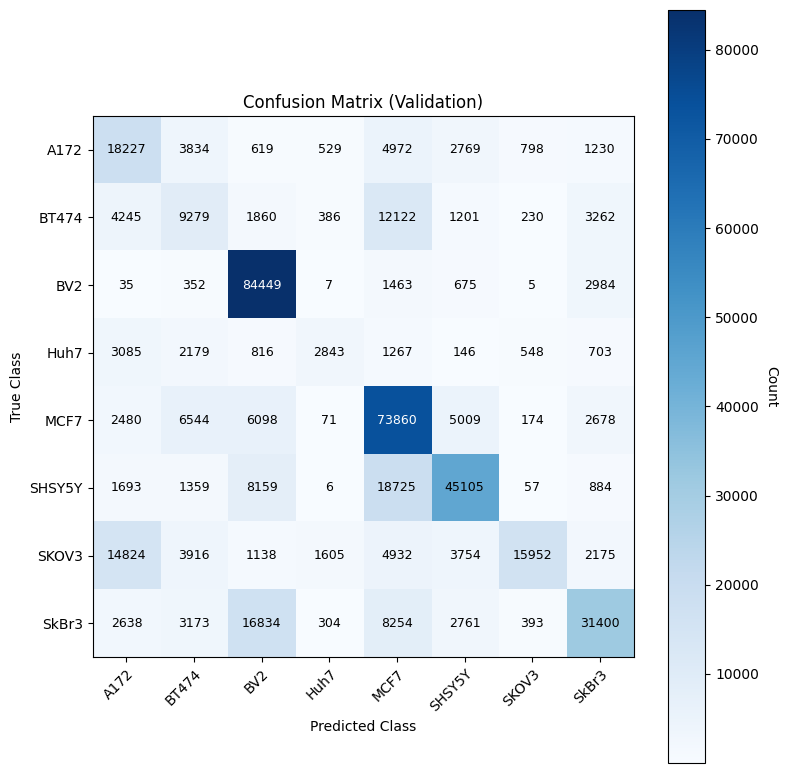

In [ ]:
plot_confusion_matrix_named(
    cm_knn,
    class_names=class_names,
    title="Confusion Matrix (Validation)"
)


L'analisi evidenzia una forte variabilità delle prestazioni tra le classi confermando quindi che l'accuracy globale non è sufficiente a descrivere il comportamento del modello.
Notiamo che classi come BV2, MCF7 e SHSY5Y hanno una marcata concentrazione lungo la diagonale indicando quindi una buona separazione nello spazio delle features.
Queste classi sembrano essere ben rappresentate dagli embedding, probabilmente grazie a caratteristiche visive distintive.
Ci sono classi che mostrano una distribuzione più dispersa come, ad esempio,BT474 e A172 che presentano confusione con più classi indicando quindi una rappresentazione meno compatta e notiamo, in particolare, confusioni sistematiche tra le seguenti classi:

* MCF7 <-> SHSY5Y

* BT474 <-> A172

* SkBr3 <-> BV2

Il che ci suggerisce che alcune classi condividano pattern visivi simili che il modello non riesce a separare completamente.

Essendo il dataset sbilanciato lo è anche il numero di campioni per classe e quindi ciò implica che le classi più popolose dominano l'accuracy globale e le classi con pochi campioni possono risultare penalizzate anche se ben rappresentate.

Andiamo ora a confrontare i due metodi (Centroidi vs k-NN) per vedere chi confronta in modo migliore su ogni singola classe

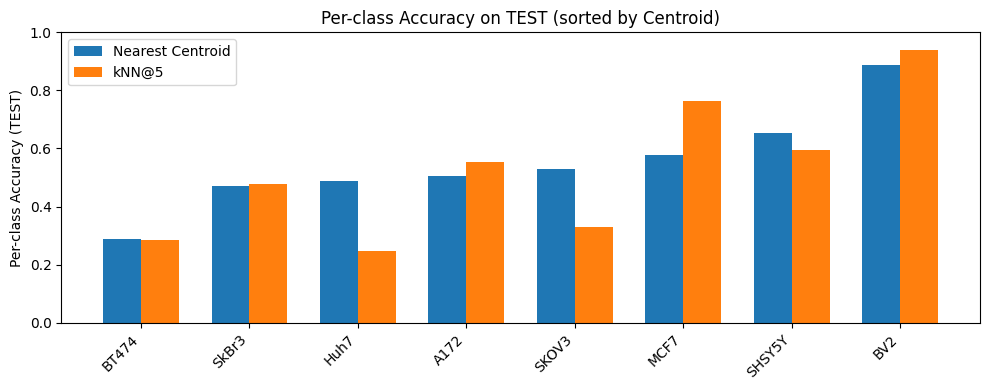

In [ ]:
def per_class_acc(cm):
    denom = cm.sum(axis=1)
    out = np.zeros((cm.shape[0],), dtype=np.float32)
    for i in range(cm.shape[0]):
        out[i] = (cm[i, i] / denom[i]) if denom[i] > 0 else 0.0
    return out

acc_cent = per_class_acc(cm_cent)
acc_knn  = per_class_acc(cm_knn)

w = 0.35
xx = np.arange(C)

order = np.argsort(acc_cent)

plt.figure(figsize=(10,4))
plt.bar(xx - w/2, acc_cent[order], width=w, label="Nearest Centroid")
plt.bar(xx + w/2, acc_knn[order],  width=w, label="kNN@5")
plt.xticks(xx, [class_names[i] for i in order], rotation=45, ha="right")
plt.ylim(0, 1)
plt.ylabel("Per-class Accuracy (TEST)")
plt.title("Per-class Accuracy on TEST (sorted by Centroid)")
plt.legend()
plt.tight_layout()
plt.show()

Per superare i limiti di una metrica globale come l'accuratezza media, è stata implementata un'analisi delle prestazioni per singola classe. Inizialmente è stata definita la funzione `per_class_acc(cm)`, che calcola la Recall per ogni etichetta normalizzando la diagonale della matrice di confusione rispetto al numero totale di campioni reali (supporto).

\
$$\text{Recall}_i = \frac{TP_i}{TP_i + FN_i}$$
\
Per rendere il confronto leggibile e significativo, le classi sull'asse delle ascisse non sono state disposte in ordine alfabetico, ma sono state ordinate in modo crescente basandosi sulle prestazioni del classificatore baseline (Nearest Centroid). Questo ordinamento `np.argsort(acc_cent)` permette di visualizzare il grafico seguendo un gradiente di "difficoltà": a sinistra troviamo le classi più complesse per il modello a centroidi, a destra quelle più facilmente separabili.


L'analisi del grafico a barre evidenzia un comportamento eterogeneo tra i due metodi: nella parte sinistra del grafico, notiamo che per la classe BT474 le prestazioni rimangono basse (~30%) con entrambi i metodi. Questo conferma quanto osservato nella matrice di confusione: la sovrapposizione morfologica con altre classi (es. MCF7) è tale che né un approccio globale (Centroidi) né uno locale (k-NN) riescono a districare efficacemente gli embedding. Un dato interessante e controintuitivo emerge per le classi Huh7 e SKOV3, dove il metodo Nearest Centroid supera il k-NN. \
Il k-NN mostra la sua superiorità nel gestire **decision boundaries non lineari** sulla classe MCF7, dove otteniamo un netto incremento di accuratezza rispetto ai centroidi. Anche su classi già ben performanti come BV2 e A172, il k-NN offre un ulteriore margine di miglioramento.

La Figura successiva mostra la variazione netta di accuratezza ($\Delta$ Accuracy) passando dal classificatore a Centroidi al k-NN ($k=5$)

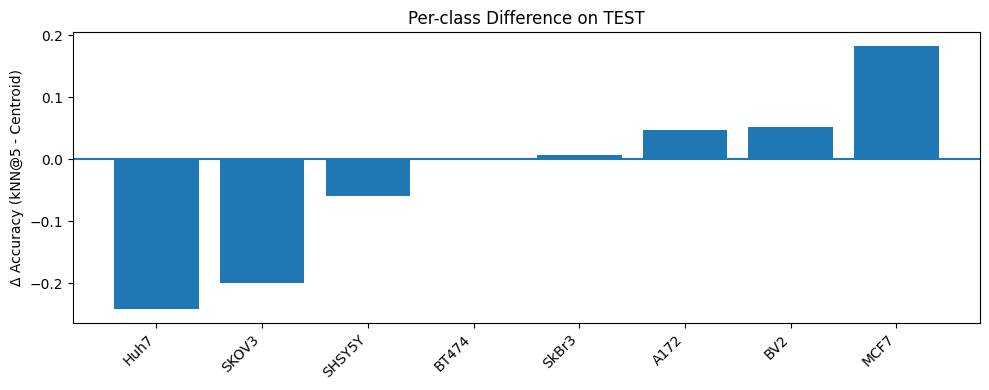

In [ ]:
diff = acc_knn - acc_cent
order2 = np.argsort(diff)

plt.figure(figsize=(10,4))
plt.bar(xx, diff[order2])
plt.axhline(0.0)
plt.xticks(xx, [class_names[i] for i in order2], rotation=45, ha="right")
plt.ylabel("Δ Accuracy (kNN@5 - Centroid)")
plt.title("Per-class Difference on TEST")
plt.tight_layout()
plt.show()

Il grafico evidanzia quello visto precedentemente nel grafico a barre, infatti è stata calcolata la differenza algebrica delle accuratezze per ogni singola classe:$$\Delta_{class} = \text{Accuracy}_{kNN} - \text{Accuracy}_{Centroid}$$Nel grafico risultante l'asse delle ascisse è stato ordinato in base a questo valore differenziale `np.argsort(diff)`. La linea orizzontale allo zero rappresenta il punto di parità: le barre positive (verso l'alto) indicano un miglioramento delle performance con il k-NN, mentre le barre negative (verso il basso) segnalano una regressione rispetto alla baseline dei Centroidi.

Sul lato destro, osserviamo che il k-NN porta benefici sostanziali. Il caso più eclatante è la classe MCF7, con un guadagno di quasi +0.20 (20%).
Sul lato sinistro, notiamo cali prestazionali marcati per Huh7 (circa -0.24) e SKOV3 (circa -0.20). In questi casi specifici, il metodo a Centroidi risultava superiore. \
Al centro del grafico, la classe BT474 mostra una variazione pressoché nulla ($\Delta \approx 0$). Come evidenziato nelle analisi precedenti, questa classe soffre di una sovrapposizione strutturale con altre popolazioni; cambiare il tipo di classificatore (da geometrico a topologico) non risolve l'ambiguità di fondo presente negli embedding generati dal modello.

### Class-Wise Accuracy

In [ ]:
def classwise_accuracy(y_true, y_pred, num_classes):
    y_true = np.asarray(y_true)
    y_pred = np.asarray(y_pred)
    acc = np.zeros(num_classes, dtype=np.float32)
    support = np.zeros(num_classes, dtype=np.int64)
    for c in range(num_classes):
        m = (y_true == c)
        support[c] = int(m.sum())
        acc[c] = float((y_pred[m] == c).mean()) if m.any() else np.nan
    return acc, support

acc_cw, support_cw = classwise_accuracy(val_y, val_pred, C)

rows = []
for i in range(C):
    name = class_names[i] if "class_names" in globals() else str(i)
    rows.append((i, name, support_cw[i], acc_cw[i]))

rows_sorted = sorted(rows, key=lambda x: (np.nan_to_num(x[3], nan=-1), x[2]))

print("Class-wise accuracy (VAL) — sorted by accuracy\n")
print(f"{'id':>2}  {'class':<18}  {'support':>8}  {'acc':>6}")
print("-"*42)
for i, name, supp, acc in rows_sorted:
    print(f"{i:>2}  {name:<18}  {supp:>8}  {acc:>6.3f}")

k = 3
worst = rows_sorted[:k]
best  = rows_sorted[-k:][::-1]

print("\nWorst classes:")
for i, name, supp, acc in worst:
    print(f" - {name} (id={i}) acc={acc:.3f}  support={supp}")

print("\nBest classes:")
for i, name, supp, acc in best:
    print(f" - {name} (id={i}) acc={acc:.3f}  support={supp}")



Class-wise accuracy (VAL) — sorted by accuracy

id  class                support     acc
------------------------------------------
 3  Huh7                    3632   0.276
 1  BT474                  14526   0.303
 6  SKOV3                   5531   0.325
 7  SkBr3                  29693   0.490
 0  A172                   15688   0.528
 5  SHSY5Y                 28199   0.583
 4  MCF7                   39252   0.750
 2  BV2                    45033   0.929

Worst classes:
 - Huh7 (id=3) acc=0.276  support=3632
 - BT474 (id=1) acc=0.303  support=14526
 - SKOV3 (id=6) acc=0.325  support=5531

Best classes:
 - BV2 (id=2) acc=0.929  support=45033
 - MCF7 (id=4) acc=0.750  support=39252
 - SHSY5Y (id=5) acc=0.583  support=28199


L’analisi dell’accuracy per classe mostra una marcata variabilità nelle prestazioni del classificatore basato su prototipi globali.
La classe BV2 risulta la più facilmente discriminabile, con un’accuracy pari a 0.868, indicando una buona compattezza intra-classe e una chiara separazione nello spazio degli embedding DINOv3.

Al contrario, classi come BT474, A172 e SkBr3 presentano prestazioni più contenute, con accuracy comprese tra 0.31 e 0.50, suggerendo una maggiore sovrapposizione con altre classi nello spazio latente o una maggiore variabilità morfologica.

È inoltre rilevante osservare che tali differenze non sembrano dipendere esclusivamente dal numero di campioni disponibili per ciascuna classe: alcune classi numerose (ad esempio SkBr3 e MCF7) mostrano comunque accuracy moderate. Questo indica che la difficoltà del compito è principalmente legata alle caratteristiche visive delle classi piuttosto che allo sbilanciamento del dataset.

# Protonet

Le **Prototypical Networks (ProtoNet)** sono un approccio di **few-shot learning**
basato sull’idea di rappresentare ciascuna classe tramite un **prototipo**,
ovvero un punto rappresentativo nello spazio delle feature.

In ogni episodio few-shot, un piccolo insieme di esempi etichettati
(**support set**) viene utilizzato per calcolare un prototipo per ciascuna classe,
tipicamente la media dei relativi embedding.
I campioni da classificare (**query set**) vengono quindi assegnati alla classe il cui prototipo risulta più vicino secondo una metrica di distanza.

Nel nostro scenario abbiamo utilizzato due metriche di distanza:
- Distanza euclidea
- Cosine Similarity

Nel nostro caso il backbone DINOv3 è congelato e hanno dimensione 384 corrispondente alla dimensionalità standard prevista dal backbone DINOv3.
Per l’episodic evaluation entrano in gioco tre layer:
- con *nn.Linear* applichiamo una proiezione lineare che riduce la dimensionalità degli embedding da 384 a 256
- mentre con *nn.Relu* e *nn.Tahn* introducono non linearità nell’head per rendere più flessibile lo spazio di embedding prima del calcolo dei prototipi.

Successivamente, dopo la baseline “globale” (prototipi calcolati su tutto il training set), valutiamo le rappresentazioni in un vero scenario **few-shot** tramite episodi.

In ogni episodio:
- si selezionano \(N\) classi (N-way)
- per ciascuna classe si estraggono \(K\) esempi di supporto (K-shot) per costruire i prototipi
- si classificano \(Q\) esempi query per classe confrontandoli con i prototipi tramite distanza euclidea e cosine similarity


A differenza dei classificatori tradizionali, le Prototypical Networks
non apprendono un classificatore parametrico, ma sfruttano direttamente
la struttura geometrica dello spazio delle feature.
Questo le rende particolarmente adatte a scenari in cui il numero di esempi
per classe è molto limitato.




Sapendo che **Protonet** non lavora su batch casuali ma su episodi ci serve uno strumento che possa dirci in maniera veloce quali informazioni appartengono ad una determinata classe, andiamo a costruire quindi una funzione che trasforma un vettore di etichette in una struttura organizzata per classe

In [ ]:
def build_idx_by_class(y):

    y = np.asarray(y)
    C = int(y.max()) + 1
    idx_by_class = [np.where(y == c)[0] for c in range(C)]
    return idx_by_class

idx_train = build_idx_by_class(train_y)
print("Num classi:", len(idx_train))
print("Esempio: campioni classe 0 =", len(idx_train[0]))

Num classi: 8
Esempio: campioni classe 0 = 83175


La funzione `build_idx_by_class` ci permette di creare una mappa degli indirizzi per rendere efficiente il campionamento episodico.

*y* ci dice su ogni riga che tipo di cellula si trova.
Ecco cosa fa il codice:

1. `C = int(y.max()) + 1`
Conta quanti tipi di cellule esistono. Il codice scorre la lista, vede che il numero più alto è 7. Quindi calcola: 7 + 1 = 8.

2. `np.where(y == c)[0]`
Restituisce a che numero di riga si trovano le cellule di un determinato tipo. Questo è il cuore del codice. Lo fa 8 volte (una per ogni tipo di cellula).

3. `return idx_by_class`
Restituisce il risultato finale: una lista che contiene 8 liste di indirizzi

Procediamo adesso con la creazione della funzione che ci permetta di simulare gli episodi e quindi entrare nell'ottica del few-shot learning.
L'obiettivo è quello di vedere poche immagini per classe, classificare le nuove immagini e usare solo le classi presenti in quell'episodio.


In [ ]:
def sample_episode(
    emb_mm, y_mm, idx_by_class,
    n_way=5, n_support=5, n_query=15,
    rng=None,
    return_indices=False
):
    if rng is None:
        rng = np.random.default_rng()

    needed = n_support + n_query
    eligible = [c for c, idxs in enumerate(idx_by_class) if len(idxs) >= needed]

    if len(eligible) < n_way:
        raise ValueError(
            f"Classi eleggibili ({len(eligible)}) < n_way ({n_way}). "
            f"Riduci n_way o n_support/n_query."
        )

    classes = rng.choice(eligible, size=n_way, replace=False)

    sup_idx, qry_idx = [], []
    sup_y, qry_y = [], []

    for c in classes:
        idxs = idx_by_class[c]
        chosen = rng.choice(idxs, size=needed, replace=False)
        sup = chosen[:n_support]
        qry = chosen[n_support:]

        sup_idx.append(sup)
        qry_idx.append(qry)

        sup_y.append(np.full(n_support, c, dtype=np.int32))
        qry_y.append(np.full(n_query,  c, dtype=np.int32))

    sup_idx = np.concatenate(sup_idx).astype(np.int64, copy=False)
    qry_idx = np.concatenate(qry_idx).astype(np.int64, copy=False)
    sup_y   = np.concatenate(sup_y)
    qry_y   = np.concatenate(qry_y)

    support = np.asarray(emb_mm[sup_idx], dtype=np.float32)
    query   = np.asarray(emb_mm[qry_idx], dtype=np.float32)

    if return_indices:
        return support, sup_y, query, qry_y, classes, sup_idx, qry_idx
    else:
        return support, sup_y, query, qry_y, classes


La funzione `sample_episode` ci aiuta a creare la struttura degli episodi.

Ecco cosa fa il codice:
1. La funzione prende in input i parametri che devono esserci in ogni singolo episodio.

* `emb_mm` embedding di tutte le immagini
* `y_mm` vettore delle label
* `idx_by_class` lista dei campioni della classe c
* `n_way` numero di classi nell'episodio
* `n_support` numero di esempi di support per classe (**K**)
* `n_query` numero di query per classe (**Q**)
* `rng` serve per la riproducibilità dei risultati

2. Il Controllo (eligible)
Python

`eligible = [c for c, idxs in enumerate(idx_by_class) if len(idxs) >= needed]`
Controlla se le classi hanno abbastanza immagini. È una sicurezza per non far crashare il codice.

3. La selezione casuale delle classi(rng.choice)

4. La Creazione della Lista (Ciclo for)
Per ognuna delle 5 classi scelte:

Va nella tua lista di indici (idx_by_class).

Pesca a caso 20 indirizzi immagini (indici).

Li divide:

I primi 5 vanno nella lista Support (sup_idx).

I successivi 15 vanno nella lista Query (qry_idx).

Crea le etichette giuste (sup_y, qry_y) dicendo "Questi sono tutti classe X".

5.Prelievo (emb_mm[...])
In questa parte si usano i file .memmap:

Python
support = np.asarray(emb_mm[sup_idx], dtype=np.float32)
query   = np.asarray(emb_mm[qry_idx], dtype=np.float32)
Prima di questo passaggio erano usati solo numeri di riga. Ora il codice va sul disco fisso, legge solo quelle poche righe specifiche e carica in RAM i vettori pesanti (le immagini). Li converte in float32 perché PyTorch lavora meglio con questa precisione.


La funzione ci restituisce:

* **support (I Vettori di Studio):**
Sono i dati veri e propri.

* **sup_y (Le Etichette di Studio):**
Serve per dire al computer quali vettori raggruppare insieme.

* **query (I Vettori dell'Esame):**
Vettori mai visti da classificare.

* **qry_y (Le Soluzioni dell'Esame):**
Sono le risposte corrette.
Servono alla fine per vedere se il modello ha indovinato o no.

* **classes (Le Materie estratte):**
Indica quali classi sono state sorteggiate per questo episodio.

Con questa funzione siamo quindi andati a costruire un episodio few-shot valido a partire dagli embedding globali. Andiamo a verificare adesso che le dimensioni siano corrette

In [ ]:
rng = np.random.default_rng(0)

support, sup_y, query, qry_y, classes = sample_episode(
    train_emb, train_y, idx_train,
    n_way=5, n_support=5, n_query=15,
    rng=rng
)

print("classes:", classes)
print("support:", support.shape, support.dtype)
print("query:  ", query.shape, query.dtype)
print("sup_y:  ", sup_y.shape, sup_y.dtype)
print("qry_y:  ", qry_y.shape, qry_y.dtype)
print("Support per classe (conteggi):", {int(c): int((sup_y==c).sum()) for c in classes})
print("Query per classe (conteggi):", {int(c): int((qry_y==c).sum()) for c in classes})


classes: [4 5 1 2 3]
support: (25, 384) float32
query:   (75, 384) float32
sup_y:   (25,) int32
qry_y:   (75,) int32
Support per classe (conteggi): {4: 5, 5: 5, 1: 5, 2: 5, 3: 5}
Query per classe (conteggi): {4: 15, 5: 15, 1: 15, 2: 15, 3: 15}


Notiamo la presenza di 5 classi distinte, nel `support` notiamo una dimensione pari a `(25,384)` dove 25 rappresenta il numero di classi per il numero di support mentre `query` ha una dimensione di `(75,384)` dove 75 rappresenta il numero di classe per il numero di query pari a 15.
Notiamo anche che si trovano i K support e le Q query per ogni classe dalle ultime due righe dell'output possiamo quindi confermare di trovarci in caso di episodi **bilanciati** e **controllati**.



  ## Protonet su episodio singolo

Il prossimo step è quello di calcolare i prototipi, dobbiamo quindi andare a fare la media degli embedding del support

In [ ]:
def compute_prototypes(support, sup_y, classes):
    prototypes = np.stack([
        support[sup_y == c].mean(axis=0) for c in classes
    ]).astype(np.float32)
    return prototypes

protos = compute_prototypes(support, sup_y, classes)
print("prototypes:", protos.shape, protos.dtype)

prototypes: (5, 384) float32


La funzione `compute_prototypes` calcola il centroide degli embedding della classe nello spazio delle feature.
Quest'operazione avviene sugli embedding di support, con mean(axis=0) si calcola la media di ogni singola coordinata, in questo modo si ottiene un vettore medio, che rappresenta il centro della classe nello spazio degli embedding.
Con `np.stack` andiamo a unire tutti i prototipi delle classi in una matrice dove ogni riga sarà un prototipo.
Quindi siamo andati ad implementare il passo centrale di **Protonet** ovvero la costruizione dei prototipi di class come media degli esempi di support in un episodio few-shot.

Il passo successivo è quello di confrontare ovvero ottenere un punteggio per ogni query q rispetto ad un prototipo .
Questi "punteggi" li otterremo vedendo due metriche:
* Cosine similarity che confronta due embedding misurando il coseno dell’angolo tra le loro direzioni nello spazio delle feature, risultando indipendente dalla loro norma e focalizzata sulla similarità semantica.
* Euclidean distance che misura la dissimilarità tra due embedding come la distanza geometrica nello spazio delle feature, tenendo conto sia della direzione sia della magnitudine dei vettori.

Procediamo con l'implementazione di queste due

In [ ]:
def l2_normalize(x, eps=1e-12):
    n = np.linalg.norm(x, axis=1, keepdims=True)
    return x / (n + eps)

def compute_logits(query, prototypes, distance="cosine"):
    if distance == "cosine":
        q = l2_normalize(query)
        p = l2_normalize(prototypes)
        logits = q @ p.T
        return logits

    elif distance == "euclidean":
        q2 = (query * query).sum(axis=1, keepdims=True)
        p2 = (prototypes * prototypes).sum(axis=1)[None, :]
        logits = -(q2 + p2 - 2.0 * (query @ prototypes.T))
        return logits

    else:
        raise ValueError("distance must be 'cosine' or 'euclidean'")


La funzione `compute_logits`  serve a trasformare il confronto tra query e prototipi in punteggi numerici (logits) che indicano quanto una query appartiene a ciascuna classe.

- *Per la cosine similarity*:
Query e prototipi vengono normalizzati
tutti i vettori hanno la stessa lunghezza. Si confronta la direzione delle query con quella dei prototipi, (misura l'angolo tra i vettori), più è vicino a 1 e più sono simili.
Il punteggio dice:
quanto la query è allineata semanticamente con ciascun prototipo.
- *Per la distanza euclidea*
Non si normalizza nulla.
Si misura quanto la query è lontana o vicina a ciascun prototipo.
Il punteggio dice:
quanto la query è vicina al centro di ogni classe.

Normalmente, la distanza Euclidea indica quanto due punti sono lontani. Se abbiamo distanza = 0 vuol dire che sono dentici, mentre distanza 100 = molto diversi.

Le reti neurali, però, ragionano al contrario: vogliono che il numero più alto sia il vincitore.
Mettendo il meno davanti alla distanza (al logit), invertiamo la logica:
Distanza 0 $\rightarrow$ Diventa -0 (Punteggio Massimo).Distanza 100 $\rightarrow$ Diventa -100 (Punteggio molto basso).In questo modo, "più vicino" diventa "punteggio più alto".



Ottenute le distanze ora dobbiamo ricordare che le nostre `qry_Y` sono label globali e, dovendole confrontare con `argmax(logits)` dobbiamo mapparle localmente

In [ ]:
def to_local_labels(y_global, classes):
    mapping = {int(c): i for i, c in enumerate(classes)}
    return np.array([mapping[int(y)] for y in y_global], dtype=np.int64)

def episode_accuracy(logits, y_local):
    pred = logits.argmax(axis=1)
    return float((pred == y_local).mean())


Con la funzione `to_local_labels` le etichette globali delle classi vengono rimappate in etichette locali valide all’interno dell’episodio, così da risultare compatibili con i logits prodotti dal modello. `episode_accuracy` L’accuratezza episodica è calcolata confrontando le predizioni ottenute selezionando il logit massimo con le etichette locali corrette.

In [ ]:
protos = compute_prototypes(support, sup_y, classes)
yq_local = to_local_labels(qry_y, classes)

log_cos = compute_logits(query, protos, distance="cosine")
log_euc = compute_logits(query, protos, distance="euclidean")

print("acc cosine:", episode_accuracy(log_cos, yq_local))
print("acc euclid:", episode_accuracy(log_euc, yq_local))


acc cosine: 0.6
acc euclid: 0.6133333333333333


Quindi a partire da un singolo episodio few-shot (5 way, 5 shot) abbiamo calcolato i prototipi di classe come media degli embedding di support e classificato i campioni di query confrontandoli con i prototipi.
Il confronto viene effetutato sia con la cosine similarity che con la distanza euclidea.
In questo episodio di esempio entrambe le metriche producono performance simili a conferma del fatto che lo spazio degli embedding presenta una struttura metrica coerente ma è bene specificare che trattandosi di un singolo episodio questi valori non sono rappresentativi e verranno successivamente mediati su molti episodi.

La nostra funzione sample by episode in questo modo è statica, dobbiamo trasformarla in un oggetto Pytorch che ci restituisce episodi in modo standard.
Per implementarlo utilizzeremo un **IterableDataset**

In [ ]:

class EpisodicIterableDataset(IterableDataset):
    def __init__(self, emb_mm, y_mm, idx_by_class,
                 n_way=5, n_support=5, n_query=15,
                 episodes_per_epoch=1000,
                 seed=0,
                 epoch=0,
                 device=None,
                 as_torch=True):
        super().__init__()
        self.emb_mm = emb_mm
        self.y_mm = y_mm
        self.idx_by_class = idx_by_class

        self.n_way = n_way
        self.n_support = n_support
        self.n_query = n_query
        self.episodes_per_epoch = episodes_per_epoch
        self.seed = int(seed)
        self.epoch = int(epoch)
        self.device = device
        self.as_torch = as_torch

    def _rng_for_worker(self):
        info = get_worker_info()
        base = self.seed + 1_000_000 * self.epoch
        if info is None:
            return np.random.default_rng(base)
        else:
            return np.random.default_rng(base + 10_000 * info.id)

    def __iter__(self):
        rng = self._rng_for_worker()

        for _ in range(self.episodes_per_epoch):
            out = sample_episode(
                self.emb_mm, self.y_mm, self.idx_by_class,
                n_way=self.n_way, n_support=self.n_support, n_query=self.n_query,
                rng=rng,
                return_indices=True
            )


            support_emb, support_y_g, query_emb, query_y_g, ep_classes, support_idx, query_idx = out

            support_y = to_local_labels(support_y_g, ep_classes)
            query_y   = to_local_labels(query_y_g, ep_classes)

            if self.as_torch:
                support_emb = torch.as_tensor(np.array(support_emb), dtype=torch.float32)
                query_emb   = torch.as_tensor(np.array(query_emb),   dtype=torch.float32)

                support_y   = torch.as_tensor(support_y,   dtype=torch.long)
                query_y     = torch.as_tensor(query_y,     dtype=torch.long)


                support_y_g = torch.as_tensor(np.array(support_y_g), dtype=torch.long)
                query_y_g   = torch.as_tensor(np.array(query_y_g),   dtype=torch.long)

                ep_classes  = torch.as_tensor(np.array(ep_classes),  dtype=torch.long)

                support_idx = torch.as_tensor(np.array(support_idx), dtype=torch.long)
                query_idx   = torch.as_tensor(np.array(query_idx),   dtype=torch.long)

                if self.device is not None:
                    support_emb = support_emb.to(self.device)
                    query_emb   = query_emb.to(self.device)
                    support_y   = support_y.to(self.device)
                    query_y     = query_y.to(self.device)
                    support_y_g = support_y_g.to(self.device)
                    query_y_g   = query_y_g.to(self.device)
                    ep_classes  = ep_classes.to(self.device)
                    support_idx = support_idx.to(self.device)
                    query_idx   = query_idx.to(self.device)

            yield {
                "support_x": support_emb,
                "support_y": support_y,
                "query_x":   query_emb,
                "query_y":   query_y,
                "support_y_g": support_y_g,
                "query_y_g":   query_y_g,
                "classes":   ep_classes,
                "support_idx": support_idx,
                "query_idx":   query_idx
            }


La classe `EpisodicIterableDataset` eredita da `IterableDataset` di pytorch che ci permette di creare un dataset che non indicizza il **__getitem__** ma genera i dati mediante **__iter__**, questo la rende perfetta per l'episodic sampling in quanto ogni singolo episodio non corrisponde ad una singola immagine,
noi non andiamo ad iterare su immagini ma sugli episodi già pronti.

L'`init` prende al suo interno:
* `emb_mm` gli embeddings di DINOv3
* `y_mm` i label global di ogni sample
* `idx_by_class` un'array dove sono contenuti gli indici dei campioni di ogni classe

oltre che gli iper parametri del few shot quali:

* `n_way`
* `n_support`
* `n_query`

e i parametri di loop e di riproducibilità e performance

* `seed` per garantire la riproducibilità dei risultati
* `device` per spostare il lavoro sulla GPU o sulla CPU
* `as_torch` per convertire, quando posto pari a **True**, da numpy.


La funzione `rng_for_worker()` è una funzione che evita che i worker generino episodi uguali, serve per far si lavorando su più worker nessuno di questi ragioni sullo stesso seed e otteniamo quindi episodi diversi per worker ma comunque sempre **riproducibili**.


Il **magic method** `__iter__` ci permette, come avevamo già accennato in precedenza, di generare gli episodi.
Con `rng` andiamo a creare l'RNG per questo worker, andremo successivamente a fare un ciclo sugli episodi dell'epoca dove ogni iterazione corrisponde a un'**episodio**.
Mediante l'utilizzo della funzione `sample_episode` andiamo ad ottenere `support_emb`, `support_y_g`, `query_emb`, `query_y_g` ed `ep_classes`.

Successivamente vengono resi i **label globali** in label **locali** mediante l'utilizzo della funzione precedentemente definita `to_local_labels`, questo passaggio è fondamentale per restituire a Protonet label compatte che ne semplificano il lavoro.
Questa operazione sposta `support_y` e `query_y` nello spazio 0...N-1.

Vengono convertiti gli array **numpy** in tensori con il comando `from_numpy` e nello `yield` andremo a restituire tutto ciò che ci serve per proseguire con il modello **Protonet** ovvero i dati iniziali dell'input e aggiunge le seguenti variabili:
* `support_y_g`
* `query_y_g`
* `classes`

Dove le prime due corripondono ai label globali mentre la terza ci dice quali classi globali troviamo nell'episodio.

Questa classe ci permette di trasformare gli embedding precedentemente estratti con DINOv3 in un flusso di episodi few-shot che possiamo dare a Protonet senza dover chiamare manualmente la funzione `sample_episode()`.
Con questa classe il `DataLoader` ci restituirà un **batch** già pronto contenente:

* Support set (N-way,K-shot)
* Query set (N-way, Q-query)
* Label locali (0...N-1)

In questo modo la nostra unità di misura passa da un campione a un **episodio**.


Andiamo a creare una funzione che ci permetta di calcolare l'f1 score

In [ ]:
idx_train = build_idx_by_class(train_y)
idx_val   = build_idx_by_class(val_y)
idx_test  = build_idx_by_class(test_y)

def f1_macro(pred, target, n_classes):
    f1s = []

    for c in range(n_classes):
        tp = ((pred == c) & (target == c)).sum().float()
        fp = ((pred == c) & (target != c)).sum().float()
        fn = ((pred != c) & (target == c)).sum().float()

        denom = 2 * tp + fp + fn
        if denom == 0:
            f1 = torch.tensor(0.0, device=pred.device)
        else:
            f1 = 2 * tp / denom

        f1s.append(f1)

    return torch.stack(f1s).mean()

Ogni singolo episodio avrà un unico valore di F1 che rappresenta la media degli F1 delle classi all'interno dell'episodio.

## Implementazione Protonet


In [ ]:
class ProtoNetHead(nn.Module):
    def __init__(self, in_dim=384, proj_dim=256, distance="cosine",activation="relu"):
        super().__init__()
        self.distance = distance
        if activation == "relu":
          act=nn.ReLU()
        elif activation == "tanh":
          act=nn.Tanh()
        else:
          raise ValueError("Activation must be relu or tanh")
        self.head = nn.Sequential(
        nn.Linear(in_dim, proj_dim),
        act,
        nn.Linear(proj_dim, proj_dim),
        )

    def forward(self, support_x, support_y, query_x, query_y, classes,return_preds=False):
        support = self.head(support_x)
        query   = self.head(query_x)

        classes = torch.as_tensor(classes, device=support_y.device, dtype=support_y.dtype)

        protos = torch.stack([support[support_y == c].mean(dim=0) for c in classes], dim=0)

        if self.distance == "cosine":
            query  = F.normalize(query, dim=1)
            protos = F.normalize(protos, dim=1)
            logits = (query @ protos.t()) * 10.0
        elif self.distance == "euclidean":
            q2 = (query * query).sum(dim=1, keepdim=True)
            p2 = (protos * protos).sum(dim=1).unsqueeze(0)
            logits = -(q2 + p2 - 2.0 * (query @ protos.t()))
        else:
            raise ValueError("distance must be 'cosine' or 'euclidean'")

        eq = (query_y[:, None] == classes[None, :])
        y_local = eq.float().argmax(dim=1).long()

        loss = F.cross_entropy(logits, y_local)
        pred = logits.argmax(dim=1)
        acc  = (pred == y_local).float().mean()
        f1  = f1_macro(pred, y_local, n_classes=len(classes))

        if return_preds:
          preds_local=logits.argmax(dim=1)
          preds_global = classes[preds_local]
          return loss,acc,f1,preds_global
        return loss, acc,f1

`ProtoNetHead` definisce il modello Prototypical Network utilizzato nel progetto più una projection head.
Prima di tutto si imposta la metrica e si sceglie l'attivazione da utilizzare.  Successivamente ciò che viene fatto nell'init è:
- *nn.Linear* che riorganizza gli embedding da 384 a 256 dimensioni tramite una trasformazione lineare;
- *nn.ReLu* permette alla head di adattare lo spazio degli embedding al contesto few-shot episodico introducendo non linearità

Oppure

- *nn.Tanh* permette alla head di rimodellare lo spazio degli embedding nel contesto few-shot episodico introducendo una non linearità limitata e simmetrica, favorendo una rappresentazione più stabile e regolarizzata.


Il secondo layer lineare riorganizza le feature dopo la non linearità .

La funzione `forward` ci consente di passare nel modello i dati caricati per la produzione di output.
Ogni chiamata alla funzione `forward` corrisponde un episodio con il support set, query set e le clssi scelte nell'episodio. (lavoriamo su embedding adattati (.head)).
 `classes` rende classes un tensore sul device giusto.
 Con `protos` si ottiene una matrice dove ogni prototipo è associato a una delle n classi dell'episodio, (cambia ad ogni episodio). Lo step successivo è quello di calcolare i logit in base alla misura di distanza che si sta considerando.
 Per la cosine normalizza la norma a 1, applica il confronto tra query e prototipi con un prodotto scalare e infine viene applicata la softmax per evidenziare le differneze.
 Per il caso della distanza euclidea visto che c'è il meno un logit più alto indica una distanza minore.
 In entrambi i casi viene restituita una matrice con come riga le riga le query e come colonne le classi dell'episodio.

  Con `eq` si rende la label globale di ciascuna query nell’indice della classe corrispondente all’interno dell’episodio. Infine si calcola la loss, l'accuratezza e l'F1 per ogni episodio.

 Il modello è “dinamico” perché a ogni forward cambia il set di classi (classes), cambiano i prototipi (media dei support dell’episodio) e cambia la mappatura delle label in spazio locale; invece i parametri appresi sono quelli della projection head e (implicitamente) la geometria che essa induce nello spazio metrico.

In [ ]:
def train_protonet_head(
    model,
    train_emb, train_y, idx_train,
    val_emb, val_y, idx_val,
    epochs=10,
    episodes_per_epoch=1000,
    n_way=5, n_support=5, n_query=15,
    lr=1e-3,
    weight_decay=0.0,
    device="cuda",
    seed=123,
    optimizer_name="adamwd",
    num_workers=0,
    eval_episodes=200,
    log_every=100,
    momentum=0.9,
    nesterov=True
    ):
    device = torch.device(device)
    model.to(device)

    if optimizer_name.lower() == "adamwd":
      optimizer = torch.optim.AdamW(model.parameters(), lr=lr, weight_decay=weight_decay)
    elif optimizer_name.lower() == "sgd":
      optimizer = torch.optim.SGD(
            model.parameters(),
            lr=lr,
            momentum=momentum,
            weight_decay=weight_decay,
            nesterov=nesterov
        )
    else:
        raise ValueError("Optimizer name must be adamw or sgd")

    history = {
        "train_epoch_loss": [],
        "train_epoch_acc": [],
        "train_epoch_f1": [],
        "train_eval_loss": [],
        "train_eval_acc": [],
        "train_eval_f1": [],
        "val_loss": [],
        "val_acc": [],
        "val_f1": [],
        "train_step_loss": [],
        "train_step_acc": [],
        "train_step_f1": [],
    }



    for epoch in range(epochs):
        model.train()
        running_losses, running_accs, running_f1s = [], [], []
        ds_train = EpisodicIterableDataset(
            train_emb, train_y, idx_train,
            n_way=n_way, n_support=n_support, n_query=n_query,
            episodes_per_epoch=episodes_per_epoch,
            seed=seed + epoch,
            device=None,
            as_torch=True
        )
        dl_train = DataLoader(ds_train, batch_size=None, num_workers=num_workers)
        for step, batch in enumerate(dl_train, start=1):
            sx = batch["support_x"].to(device)
            qx = batch["query_x"].to(device)
            sy_g = batch["support_y_g"].to(device)
            qy_g = batch["query_y_g"].to(device)
            cls_raw = batch["classes"]
            if torch.is_tensor(cls_raw):
                cls = cls_raw.to(device=device, dtype=sy_g.dtype)
            else:
                cls = torch.as_tensor(cls_raw, device=device, dtype=sy_g.dtype)

            optimizer.zero_grad(set_to_none=True)
            loss, acc, f1 = model(sx, sy_g, qx, qy_g, cls)

            if not torch.isfinite(loss):
                raise RuntimeError(f"Non-finite loss at epoch={epoch}, step={step}: {loss.item()}")

            loss.backward()
            optimizer.step()

            history["train_step_loss"].append(loss.item())
            history["train_step_acc"].append(acc.item())
            history["train_step_f1"].append(f1.item())

            running_losses.append(loss.item())
            running_accs.append(acc.item())
            running_f1s.append(f1.item())

            if log_every and (step % log_every == 0 or step == episodes_per_epoch):
                print(
                    f"[TRAIN] epoch {epoch+1}/{epochs} | step {step}/{episodes_per_epoch} "
                    f"| loss={np.mean(running_losses):.4f} | acc={np.mean(running_accs):.4f} | f1={np.mean(running_f1s):.4f}"
                )

            if step >= episodes_per_epoch:
                break

        epoch_train_loss = float(np.mean(running_losses))
        epoch_train_acc  = float(np.mean(running_accs))
        epoch_train_f1   = float(np.mean(running_f1s))

        history["train_epoch_loss"].append(epoch_train_loss)
        history["train_epoch_acc"].append(epoch_train_acc)
        history["train_epoch_f1"].append(epoch_train_f1)

        model.eval()

        train_eval_loss, train_eval_acc, train_eval_f1 = eval_head_with_loader_global(
            model, train_emb, train_y, idx_train,
            episodes=eval_episodes,
            n_way=n_way, n_support=n_support, n_query=n_query,
            device=device,
            seed=1000 + epoch,
            num_workers=num_workers,
            log_every=0,
            prefix="TRAIN-EVAL"
            )

        val_loss, val_acc, val_f1 = eval_head_with_loader_global(
            model, val_emb, val_y, idx_val,
            episodes=eval_episodes,
            n_way=n_way, n_support=n_support, n_query=n_query,
            device=device,
            seed=2000 + epoch,
            num_workers=num_workers,
            log_every=0,
            prefix="VAL"
            )

        history["train_eval_loss"].append(train_eval_loss)
        history["train_eval_acc"].append(train_eval_acc)
        history["train_eval_f1"].append(train_eval_f1)

        history["val_loss"].append(val_loss)
        history["val_acc"].append(val_acc)
        history["val_f1"].append(val_f1)

        print(
            f"[EPOCH {epoch+1}/{epochs}] "
            f"train_epoch loss={epoch_train_loss:.4f} acc={epoch_train_acc:.4f} f1={epoch_train_f1:.4f} | "
            f"train_eval loss={train_eval_loss:.4f} acc={train_eval_acc:.4f} f1={train_eval_f1:.4f} | "
            f"val loss={val_loss:.4f} acc={val_acc:.4f} f1={val_f1:.4f}"
        )

    return history


L'obiettivo della funzione `train_protonet_head` è quello di addestrare la projection head del Prototypical Network in regime few-shot episodico, monitorando le prestazioni sia durante il training sia su validation.

Come primo step c'è la scelta dell'ottimizzatore da utilizzare.
Poi si inizializza `history` che registra l'andamento delle metriche:
- per episodio;
- per epoca;
- su training e validation

Il primo ciclo di for permette il loop sulle epoche e mette il modello il modalità training e si crea il dataset episodico, a questo punto per ogni epoca:

Si istanzia EpisodicIterableDataset usando train_emb, train_y e idx_train, con i parametri dell’episodio (n_way, n_support, n_query) e episodes_per_epoch.
Il seed=seed+epoch serve a variare gli episodi a ogni epoca in modo riproducibile.

Si crea il DataLoader con batch_size=None perché ogni “item” è già un episodio completo (non serve batching classico). num_workers controlla il parallelismo nella generazione degli episodi.

Dentro il loop degli episodi (for step, batch ...):

Si estraggono e si portano su device i tensori:

- support_x e query_x: embedding (o features) per support e query

- support_y_g e query_y_g: etichette globali

- classes: l’elenco delle classi estratte in quell’episodio

Si fa optimizer.zero_grad(set_to_none=True) per azzerare i gradienti in modo più efficiente.

Si chiama model(sx, sy_g, qx, qy_g, cls): il modello restituisce direttamente loss, accuracy e f1 dell’episodio. In pratica qui la head/prototypical logic calcola prototipi dal support set e valuta la query.

Controllo di sicurezza: se la loss non è finita (NaN o Inf), interrompe con errore (utile per debugging).

Backprop e update:

- loss.backward()

- optimizer.step()

Logging e salvataggio metriche:

Per ogni episodio salva in history["train_step_*"] loss/acc/f1.

Accumula anche in liste running_losses/accs/f1s per fare medie progressive.

Ogni log_every episodi (o all’ultimo episodio) stampa la media corrente.

Fine epoca (metriche “epoch-level”):

- Calcola la media di loss/acc/f1 sugli episodi dell’epoca e le salva in: train_epoch_loss, train_epoch_acc, train_epoch_f1

Valutazione in modalità eval():

model.eval() disattiva dropout/bn update ecc.

Esegue due valutazioni episodiche con eval_head_with_loader_global:

TRAIN-EVAL: valutazione su episodi campionati dal training set (serve per capire generalizzazione “in-distribution” e confrontare con il train loss episodico, che è ottimizzato step-by-step).

VAL: valutazione su episodi campionati da validation set (misura la generalizzazione out-of-sample).

I seed separati (1000+epoch, 2000+epoch) rendono le valutazioni ripetibili e indipendenti dal training sampling.

Salvataggio delle metriche di evaluation:

train_eval_loss/acc/f1 finiscono in history["train_eval_*"]

val_loss/acc/f1 finiscono in history["val_*"]

Stampa riepilogo epoca:

Una riga con: metrica media del training “online” + train-eval + validation.

Output finale:

La funzione ritorna history, che contiene l’intera traccia delle metriche:

per step (episodio) e per epoca

su training (train_epoch + train_eval) e validation


In [ ]:
@torch.no_grad()
def eval_head_with_loader_global(
    model,
    emb, y, idx_by_class,
    episodes=200,
    n_way=5, n_support=5, n_query=15,
    device="cuda",
    seed=123,
    num_workers=0,
    log_every=0,
    prefix="EVAL"):
    device = torch.device(device)
    model.to(device)
    model.eval()

    ds = EpisodicIterableDataset(
        emb, y, idx_by_class,
        n_way=n_way, n_support=n_support, n_query=n_query,
        episodes_per_epoch=episodes,
        seed=seed,
        device=None,
        as_torch=True
    )
    dl = DataLoader(ds, batch_size=None, num_workers=num_workers)

    losses, accs, f1s = [], [], []

    for i, batch in enumerate(dl, start=1):
        sx = batch["support_x"].to(device)
        qx = batch["query_x"].to(device)
        sy_g = batch["support_y_g"].to(device)
        qy_g = batch["query_y_g"].to(device)

        cls_raw = batch["classes"]
        if torch.is_tensor(cls_raw):
            cls = cls_raw.to(device=device, dtype=sy_g.dtype)
        else:
            cls = torch.as_tensor(cls_raw, device=device, dtype=sy_g.dtype)

        loss, acc, f1 = model(sx, sy_g, qx, qy_g, cls)

        if not torch.isfinite(loss):
            print(f"[{prefix}] NON-FINITE LOSS at episode {i}: {loss.item()}")
            return float("nan"), float("nan"), float("nan")

        losses.append(loss.item())
        accs.append(acc.item())
        f1s.append(f1.item())

        if log_every and (i % log_every == 0 or i == episodes):
            print(f"[{prefix}] ep {i}/{episodes} | loss={np.mean(losses):.4f} | acc={np.mean(accs):.4f}")

        if i >= episodes:
            break

    return float(np.mean(losses)), float(np.mean(accs)), float(np.mean(f1s))

Una volta completata la fase di training, in cui i pesi della head vengono ottimizzati tramite episodi few-shot, si passa alla fase di valutazione.
In questa fase i pesi appresi vengono mantenuti fissi e il modello viene testato su una sequenza di nuovi episodi few-shot.
Per ciascun episodio cambiano il support set e il query set, mentre la head rimane invariata.
L’obiettivo della funzione  `eval_head_with_loader_global` è misurare le prestazioni del modello calcolando la loss media e l’accuracy media su un numero prefissato di episodi, fornendo una stima stabile della capacità di generalizzazione del modello. Con `ds` definiamo un generatore di episodi che contiene tutti i parametri chiave, `dl` è il data loader dove ogni iterazione restituisce un singolo episodio. Il ciclo di for serve ad iterare su tutti gli episodi, si prendono tutti i tensori e si spostano su device. Con `model` calcoliamo la loss e l'accuracy. .item li restituisce in numeri python e infine nell'otuput avremo la media.

Questo è il blocco che fa classificazione few-shot.
Non carica i dati ma consuma episodi già pronti e ci restituisce la loss (l'errore nella classificazione) e l'accuracy (quanto il modello classifica bene)

In [ ]:
model = ProtoNetHead(in_dim=384, proj_dim=256, distance="cosine")

history = train_protonet_head(
    model,
    train_emb, train_y, idx_train,
    val_emb, val_y, idx_val,
    epochs=60,
    episodes_per_epoch=1000,
    eval_episodes=200,
    n_way=5, n_support=5, n_query=15,
    lr=1E-3,
    device=device,
    log_every=100,
    weight_decay=0
)

[TRAIN] epoch 1/60 | step 100/1000 | loss=0.9490 | acc=0.6525 | f1=0.6463
[TRAIN] epoch 1/60 | step 200/1000 | loss=0.8802 | acc=0.6788 | f1=0.6732
[TRAIN] epoch 1/60 | step 300/1000 | loss=0.8539 | acc=0.6902 | f1=0.6849
[TRAIN] epoch 1/60 | step 400/1000 | loss=0.8309 | acc=0.6996 | f1=0.6947
[TRAIN] epoch 1/60 | step 500/1000 | loss=0.8123 | acc=0.7066 | f1=0.7020
[TRAIN] epoch 1/60 | step 600/1000 | loss=0.7929 | acc=0.7152 | f1=0.7110
[TRAIN] epoch 1/60 | step 700/1000 | loss=0.7836 | acc=0.7180 | f1=0.7141
[TRAIN] epoch 1/60 | step 800/1000 | loss=0.7729 | acc=0.7229 | f1=0.7190
[TRAIN] epoch 1/60 | step 900/1000 | loss=0.7641 | acc=0.7260 | f1=0.7223
[TRAIN] epoch 1/60 | step 1000/1000 | loss=0.7552 | acc=0.7288 | f1=0.7251
[EPOCH 1/60] train_epoch loss=0.7552 acc=0.7288 f1=0.7251 | train_eval loss=0.6765 acc=0.7580 f1=0.7551 | val loss=0.7115 acc=0.7471 f1=0.7441
[TRAIN] epoch 2/60 | step 100/1000 | loss=0.6767 | acc=0.7600 | f1=0.7577
[TRAIN] epoch 2/60 | step 200/1000 | loss=

valutazione per capire se il modello sta imparando, quindi se abbiamo un training stabile. Visto che abbiamo un problema 5-way classification è normale ottenere valori di loss (cross-entropy) > 1. L'accuratezza ci dice quante volte classifichiamo correttamente, mentre la loss quanto il modello è sicuro della classe corretta.

In [ ]:
train_acc = history["train_eval_acc"][-1]
val_acc = history["val_acc"][-1]
train_f1 = history["train_eval_f1"][-1]
val_f1   = history["val_f1"][-1]
gap = abs(train_acc - val_acc) * 100


print(train_acc, val_acc, train_f1, val_f1, gap)


0.8285333532094955 0.8137333530187607 0.8276357573270797 0.8129806539416313 1.4800000190734797


Possiamo usare il modello anche con la distanza euclidea

In [ ]:
model2 = ProtoNetHead(
    in_dim=384,
    proj_dim=256,
    distance="euclidean"
)

history = train_protonet_head(
    model2,
    train_emb, train_y, idx_train,
    val_emb, val_y, idx_val,
    epochs=50,
    episodes_per_epoch=600,
    eval_episodes=200,
    n_way=5,
    n_support=5,
    n_query=15,
    lr=1e-3,
    device=device,
    log_every=100
)

[TRAIN] epoch 1/50 | step 100/600 | loss=0.9448 | acc=0.6485 | f1=0.6419
[TRAIN] epoch 1/50 | step 200/600 | loss=0.8849 | acc=0.6720 | f1=0.6664
[TRAIN] epoch 1/50 | step 300/600 | loss=0.8648 | acc=0.6806 | f1=0.6757
[TRAIN] epoch 1/50 | step 400/600 | loss=0.8451 | acc=0.6906 | f1=0.6861
[TRAIN] epoch 1/50 | step 500/600 | loss=0.8303 | acc=0.6965 | f1=0.6925
[TRAIN] epoch 1/50 | step 600/600 | loss=0.8158 | acc=0.7033 | f1=0.6994
[EPOCH 1/50] train_epoch loss=0.8158 acc=0.7033 f1=0.6994 | train_eval loss=0.7323 acc=0.7335 f1=0.7302 | val loss=0.7764 acc=0.7237 f1=0.7195
[TRAIN] epoch 2/50 | step 100/600 | loss=0.7406 | acc=0.7304 | f1=0.7282
[TRAIN] epoch 2/50 | step 200/600 | loss=0.7517 | acc=0.7313 | f1=0.7287
[TRAIN] epoch 2/50 | step 300/600 | loss=0.7429 | acc=0.7342 | f1=0.7315
[TRAIN] epoch 2/50 | step 400/600 | loss=0.7360 | acc=0.7381 | f1=0.7353
[TRAIN] epoch 2/50 | step 500/600 | loss=0.7351 | acc=0.7379 | f1=0.7353
[TRAIN] epoch 2/50 | step 600/600 | loss=0.7350 | acc=

In [ ]:
train_acc = history["train_eval_acc"][-1]
val_acc   = history["val_acc"][-1]
train_f1  = history["train_eval_f1"][-1]
val_f1    = history["val_f1"][-1]
gap       = abs(train_acc - val_acc) * 100


print(train_acc, val_acc, train_f1, val_f1, gap)

0.7969333520531654 0.7884666866064072 0.7957837763428688 0.7865911036729812 0.8466665446758226


### Grafici

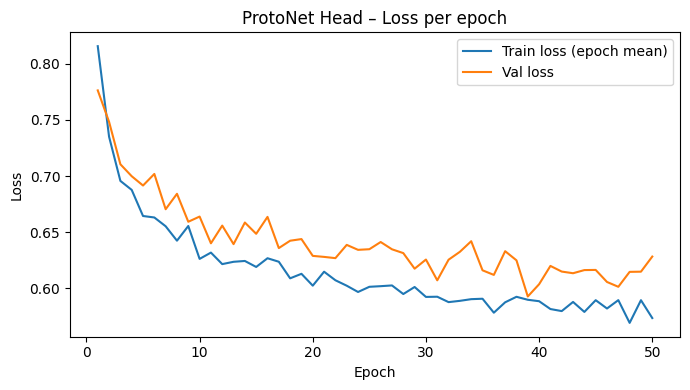

In [ ]:
epochs = np.arange(1, len(history["train_epoch_loss"]) + 1)

plt.figure(figsize=(7,4))
plt.plot(epochs, history["train_epoch_loss"], label="Train loss (epoch mean)")
plt.plot(epochs, history["val_loss"], label="Val loss")
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.title("ProtoNet Head – Loss per epoch")
plt.legend()
plt.tight_layout()
plt.show()

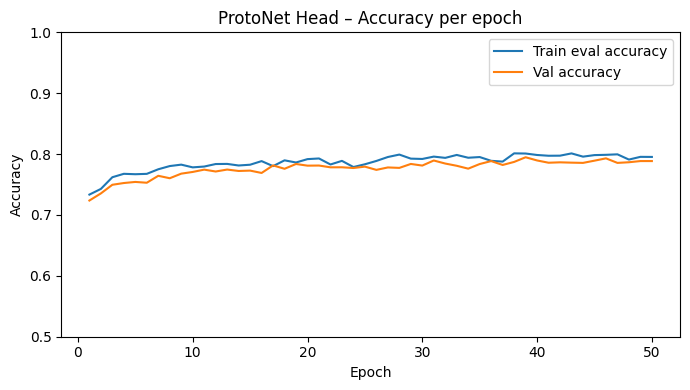

In [ ]:
plt.figure(figsize=(7,4))
plt.plot(epochs, history["train_eval_acc"], label="Train eval accuracy")
plt.plot(epochs, history["val_acc"], label="Val accuracy")
plt.xlabel("Epoch")
plt.ylabel("Accuracy")
plt.ylim(0.5, 1)
plt.title("ProtoNet Head – Accuracy per epoch")
plt.legend()
plt.tight_layout()
plt.show()

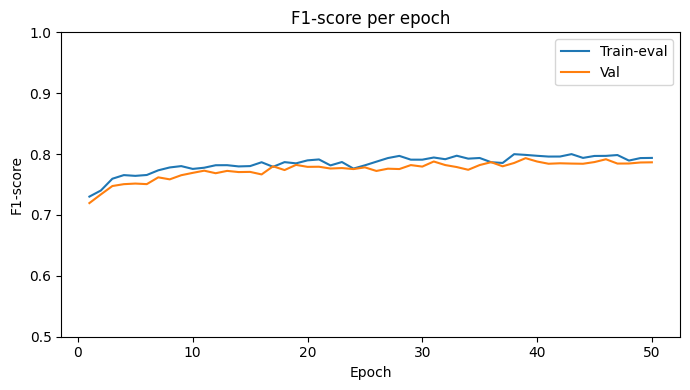

In [ ]:
epochs = np.arange(1, len(history["train_epoch_f1"]) + 1)

plt.figure(figsize=(7,4))
plt.plot(epochs, history["train_eval_f1"], label="Train-eval")
plt.plot(epochs, history["val_f1"], label="Val")

plt.xlabel("Epoch")
plt.ylabel("F1-score")
plt.ylim(0.5,1)
plt.title("F1-score per epoch")
plt.legend()
plt.tight_layout()
plt.show()

## Protonet con Tanh

Nel modello iniziale la head di classificazione utilizza una funzione non lineare (ReLU) per proiettare gli embedding estratti dal backbone in uno spazio più adatto alla separazione delle classi, considerando però che le nostre feature nel caso di **Cosine Similarity** sono normalizzate saranno quindi comprese nell'intervallo [-1,1] l'utilizzo della Relu potrebbe risultare subottimale in quanto annulla tutte le attivazioni negative che potrebbe causare una perdita di informazione rilevante in embedding che sono già centrati attorno allo 0.
In questo contesto una funzione di attivazione **tanh** potrebbe risultare più appropriata in quanto preserva sia le componenti positive che negative  mantenendo quindi una trasformazione non lineare coerente con la distribuzione delle  features.

Dopo lo svolgimento di questi esperimenti prenderemo il modello con prestazioni migliori in validazione e lo selezioneremo come modello finale, su tale modello calcoleremo le prestazioni sul **test set**.

In [ ]:
model_tanh = ProtoNetHead(activation="tanh")

history_tanh = train_protonet_head(
    model_tanh,
    train_emb, train_y, idx_train,
    val_emb, val_y, idx_val,
    epochs=60,
    episodes_per_epoch=1000,
    eval_episodes=200,
    n_way=5,
    n_support=5,
    n_query=15,
    lr=1e-3,
    device=device,
    log_every=100
)

[TRAIN] epoch 1/60 | step 100/1000 | loss=0.9557 | acc=0.6507 | f1=0.6441
[TRAIN] epoch 1/60 | step 200/1000 | loss=0.9003 | acc=0.6708 | f1=0.6646
[TRAIN] epoch 1/60 | step 300/1000 | loss=0.8792 | acc=0.6787 | f1=0.6729
[TRAIN] epoch 1/60 | step 400/1000 | loss=0.8622 | acc=0.6850 | f1=0.6795
[TRAIN] epoch 1/60 | step 500/1000 | loss=0.8465 | acc=0.6906 | f1=0.6856
[TRAIN] epoch 1/60 | step 600/1000 | loss=0.8293 | acc=0.6980 | f1=0.6931
[TRAIN] epoch 1/60 | step 700/1000 | loss=0.8213 | acc=0.7014 | f1=0.6967
[TRAIN] epoch 1/60 | step 800/1000 | loss=0.8127 | acc=0.7054 | f1=0.7008
[TRAIN] epoch 1/60 | step 900/1000 | loss=0.8044 | acc=0.7083 | f1=0.7038
[TRAIN] epoch 1/60 | step 1000/1000 | loss=0.7959 | acc=0.7117 | f1=0.7074
[EPOCH 1/60] train_epoch loss=0.7959 acc=0.7117 f1=0.7074 | train_eval loss=0.7232 acc=0.7369 f1=0.7343 | val loss=0.7618 acc=0.7309 f1=0.7270
[TRAIN] epoch 2/60 | step 100/1000 | loss=0.7279 | acc=0.7340 | f1=0.7314
[TRAIN] epoch 2/60 | step 200/1000 | loss=

In [ ]:
train_acc_tanh = history_tanh["train_eval_acc"][-1]
val_acc_tanh = history_tanh["val_acc"][-1]
train_f1_tanh = history_tanh["train_eval_f1"][-1]
val_f1_tanh   = history_tanh["val_f1"][-1]
gap_tanh = abs(train_acc_tanh - val_acc_tanh) * 100


print(train_acc_tanh, val_acc_tanh, train_f1_tanh, val_f1_tanh, gap_tanh)

0.8230666854977607 0.8142000180482865 0.8224619323015213 0.8132314366102219 0.8866667449474286


### Grafici


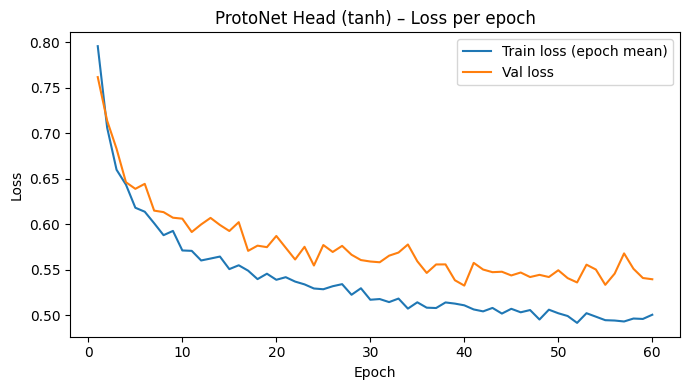

In [ ]:
epochs = np.arange(1, len(history_tanh["train_epoch_loss"]) + 1)

plt.figure(figsize=(7,4))
plt.plot(epochs, history_tanh["train_epoch_loss"], label="Train loss (epoch mean)")
plt.plot(epochs, history_tanh["val_loss"], label="Val loss")
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.title("ProtoNet Head (tanh) – Loss per epoch")
plt.legend()
plt.tight_layout()
plt.show()


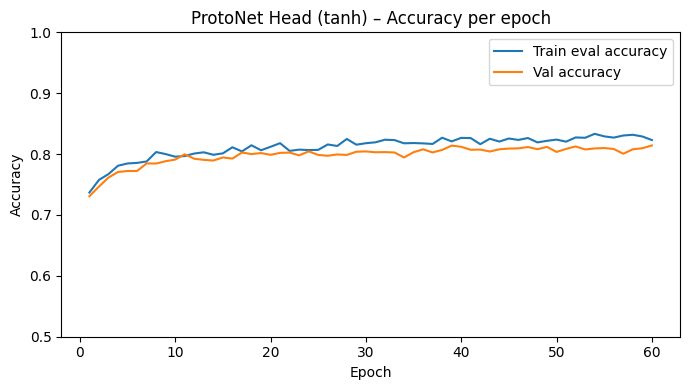

In [ ]:
epochs = np.arange(1, len(history_tanh["train_eval_acc"]) + 1)

plt.figure(figsize=(7,4))
plt.plot(epochs, history_tanh["train_eval_acc"], label="Train eval accuracy")
plt.plot(epochs, history_tanh["val_acc"], label="Val accuracy")
plt.xlabel("Epoch")
plt.ylabel("Accuracy")
plt.ylim(0.5, 1.0)
plt.title("ProtoNet Head (tanh) – Accuracy per epoch")
plt.legend()
plt.tight_layout()
plt.show()


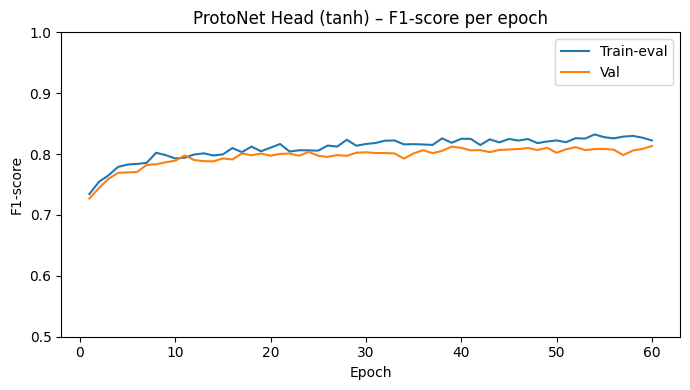

In [ ]:
epochs = np.arange(1, len(history_tanh["train_epoch_f1"]) + 1)

plt.figure(figsize=(7,4))
plt.plot(epochs, history_tanh["train_eval_f1"], label="Train-eval")
plt.plot(epochs, history_tanh["val_f1"], label="Val")

plt.xlabel("Epoch")
plt.ylabel("F1-score")
plt.ylim(0.5, 1.0)
plt.title("ProtoNet Head (tanh) – F1-score per epoch")
plt.legend()
plt.tight_layout()
plt.show()


### Grafici Comparativi

In [ ]:

def plot_compare(history_relu, history_tanh, key, ylabel, title):
    x_relu = np.arange(1, len(history_relu[key]) + 1)
    x_tanh = np.arange(1, len(history_tanh[key]) + 1)

    plt.figure(figsize=(7,4))
    plt.plot(x_relu, history_relu[key], label=f"ReLU - {key}")
    plt.plot(x_tanh, history_tanh[key], label=f"tanh - {key}")
    plt.xlabel("Epoch")
    plt.ylabel(ylabel)
    plt.title(title)
    plt.legend()
    plt.tight_layout()
    plt.show()




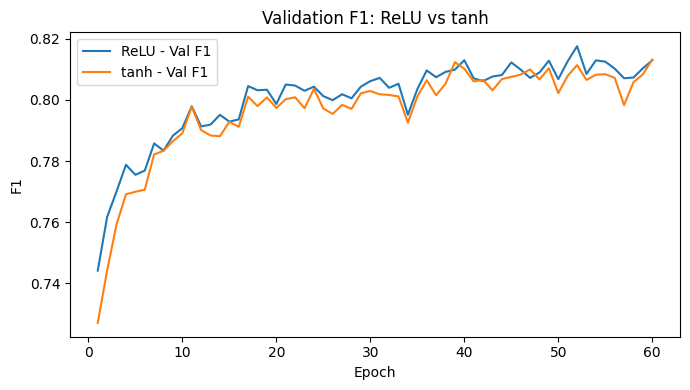

In [ ]:
epochs_relu = np.arange(1, len(history["val_f1"]) + 1)
epochs_tanh = np.arange(1, len(history_tanh["val_f1"]) + 1)

plt.figure(figsize=(7,4))
plt.plot(epochs_relu, history["val_f1"], label="ReLU - Val F1")
plt.plot(epochs_tanh, history_tanh["val_f1"], label="tanh - Val F1")
plt.xlabel("Epoch")
plt.ylabel("F1")
plt.title("Validation F1: ReLU vs tanh")
plt.legend()
plt.tight_layout()
plt.show()

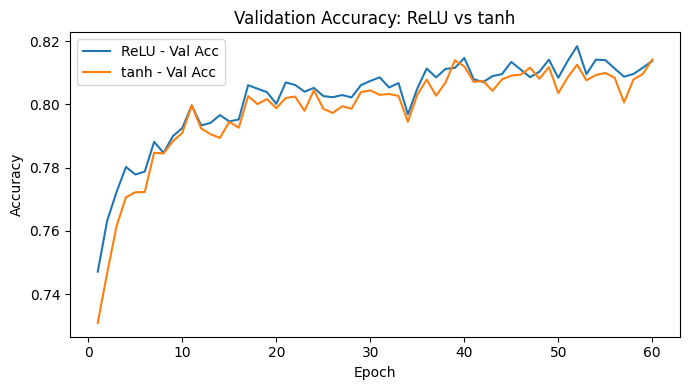

In [ ]:
epochs_relu = np.arange(1, len(history["val_acc"]) + 1)
epochs_tanh = np.arange(1, len(history_tanh["val_acc"]) + 1)

plt.figure(figsize=(7,4))
plt.plot(epochs_relu, history["val_acc"], label="ReLU - Val Acc")
plt.plot(epochs_tanh, history_tanh["val_acc"], label="tanh - Val Acc")
plt.xlabel("Epoch")
plt.ylabel("Accuracy")
plt.title("Validation Accuracy: ReLU vs tanh")
plt.legend()
plt.tight_layout()
plt.show()


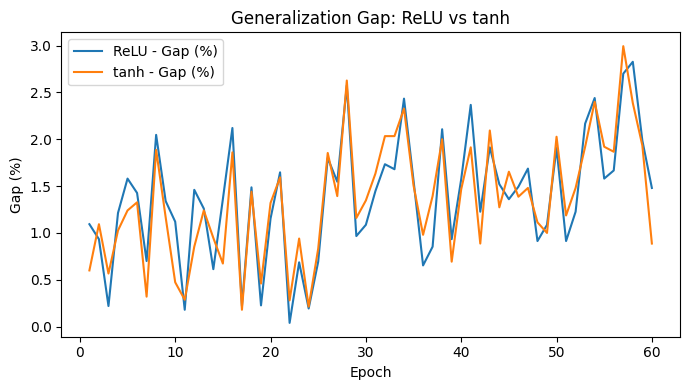

In [ ]:
gap_relu = np.abs(
    np.array(history["train_eval_acc"]) - np.array(history["val_acc"])
) * 100

gap_tanh = np.abs(
    np.array(history_tanh["train_eval_acc"]) - np.array(history_tanh["val_acc"])
) * 100

epochs_relu = np.arange(1, len(gap_relu) + 1)
epochs_tanh = np.arange(1, len(gap_tanh) + 1)

plt.figure(figsize=(7,4))
plt.plot(epochs_relu, gap_relu, label="ReLU - Gap (%)")
plt.plot(epochs_tanh, gap_tanh, label="tanh - Gap (%)")
plt.xlabel("Epoch")
plt.ylabel("Gap (%)")
plt.title("Generalization Gap: ReLU vs tanh")
plt.legend()
plt.tight_layout()
plt.show()


## Protonet Head con SGD

Andiamo a testare adesso il modello con SGD, prima di tutto andiamo a cambiare il training aggiungendo il Learning Rate scheduler

In [ ]:
def train_protonet_head(
    model,
    train_emb, train_y, idx_train,
    val_emb, val_y, idx_val,
    epochs=10,
    episodes_per_epoch=1000,
    n_way=5, n_support=5, n_query=15,
    lr=1e-3,
    weight_decay=0.0,
    device="cuda",
    seed=123,
    optimizer_name="adaw",
    num_workers=0,
    eval_episodes=200,
    log_every=100,
    momentum=0.9,
    nesterov=True,
    use_scheduler=False,
    step_size=10,
    gamma=0.5
    ):
    device = torch.device(device)
    model.to(device)

    if optimizer_name.lower() == "adamw":
      optimizer = torch.optim.AdamW(model.parameters(), lr=lr, weight_decay=weight_decay)
    elif optimizer_name.lower() == "sgd":
      optimizer = torch.optim.SGD(
            model.parameters(),
            lr=lr,
            momentum=momentum,
            weight_decay=weight_decay,
            nesterov=nesterov
        )
    else:
        raise ValueError("Optimizer name must be adamw or sgd")

    if use_scheduler:
      scheduler= torch.optim.lr_scheduler.StepLR(
          optimizer,
          step_size=step_size,
          gamma=gamma
      )
    else:
      scheduler=None

    history = {
        "train_epoch_loss": [],
        "train_epoch_acc": [],
        "train_epoch_f1": [],
        "train_eval_loss": [],
        "train_eval_acc": [],
        "train_eval_f1": [],
        "val_loss": [],
        "val_acc": [],
        "val_f1": [],
        "train_step_loss": [],
        "train_step_acc": [],
        "train_step_f1": [],
    }



    for epoch in range(epochs):
        model.train()
        running_losses, running_accs, running_f1s = [], [], []
        ds_train = EpisodicIterableDataset(
            train_emb, train_y, idx_train,
            n_way=n_way, n_support=n_support, n_query=n_query,
            episodes_per_epoch=episodes_per_epoch,
            seed=seed + epoch,
            device=None,
            as_torch=True
        )
        dl_train = DataLoader(ds_train, batch_size=None, num_workers=num_workers)
        for step, batch in enumerate(dl_train, start=1):
            sx = batch["support_x"].to(device)
            qx = batch["query_x"].to(device)
            sy_g = batch["support_y_g"].to(device)
            qy_g = batch["query_y_g"].to(device)
            cls_raw = batch["classes"]
            if torch.is_tensor(cls_raw):
                cls = cls_raw.to(device=device, dtype=sy_g.dtype)
            else:
                cls = torch.as_tensor(cls_raw, device=device, dtype=sy_g.dtype)

            optimizer.zero_grad(set_to_none=True)
            loss, acc, f1 = model(sx, sy_g, qx, qy_g, cls)

            if not torch.isfinite(loss):
                raise RuntimeError(f"Non-finite loss at epoch={epoch}, step={step}: {loss.item()}")

            loss.backward()
            optimizer.step()

            history["train_step_loss"].append(loss.item())
            history["train_step_acc"].append(acc.item())
            history["train_step_f1"].append(f1.item())

            running_losses.append(loss.item())
            running_accs.append(acc.item())
            running_f1s.append(f1.item())

            if log_every and (step % log_every == 0 or step == episodes_per_epoch):
                print(
                    f"[TRAIN] epoch {epoch+1}/{epochs} | step {step}/{episodes_per_epoch} "
                    f"| loss={np.mean(running_losses):.4f} | acc={np.mean(running_accs):.4f} | f1={np.mean(running_f1s):.4f}"
                )




            if step >= episodes_per_epoch:
                break

        epoch_train_loss = float(np.mean(running_losses))
        epoch_train_acc  = float(np.mean(running_accs))
        epoch_train_f1   = float(np.mean(running_f1s))

        history["train_epoch_loss"].append(epoch_train_loss)
        history["train_epoch_acc"].append(epoch_train_acc)
        history["train_epoch_f1"].append(epoch_train_f1)

        model.eval()

        train_eval_loss, train_eval_acc, train_eval_f1 = eval_head_with_loader_global(
            model, train_emb, train_y, idx_train,
            episodes=eval_episodes,
            n_way=n_way, n_support=n_support, n_query=n_query,
            device=device,
            seed=1000 + epoch,
            num_workers=num_workers,
            log_every=0,
            prefix="TRAIN-EVAL"
            )

        val_loss, val_acc, val_f1 = eval_head_with_loader_global(
            model, val_emb, val_y, idx_val,
            episodes=eval_episodes,
            n_way=n_way, n_support=n_support, n_query=n_query,
            device=device,
            seed=2000 + epoch,
            num_workers=num_workers,
            log_every=0,
            prefix="VAL"
            )

        history["train_eval_loss"].append(train_eval_loss)
        history["train_eval_acc"].append(train_eval_acc)
        history["train_eval_f1"].append(train_eval_f1)

        history["val_loss"].append(val_loss)
        history["val_acc"].append(val_acc)
        history["val_f1"].append(val_f1)

        current_lr = optimizer.param_groups[0]["lr"]

        print(
            f"[EPOCH {epoch+1}/{epochs}] "
            f"train_epoch loss={epoch_train_loss:.4f} acc={epoch_train_acc:.4f} f1={epoch_train_f1:.4f} | "
            f"val loss={val_loss:.4f} acc={val_acc:.4f} f1={val_f1:.4f} | "
            f"lr={current_lr:.2e}"
        )
        if scheduler is not None:
          scheduler.step()
    return history

Proviamo adesso il seguente esperimento:

| Parametro         | Valore                  |
| ----------------- | ----------------------- |
| Epoche            | 100                     |
| Episodi per epoca | 600                     |
| Learning rate     | 1e-2                    |
| n-way             | 5                       |
| n-shot            | 5                       |
| Query per classe  | 15                      |
| Ottimizzatore     | SGD                     |
| Scheduler         | StepLR (step=10, γ=0.5) |


Sia per il modello contenente la ReLU che quello contenente il tanh

### Protonet con Relu + SGD

In [ ]:
model = ProtoNetHead(
    in_dim=384,
    proj_dim=256,
    distance="cosine"
)


history = train_protonet_head(
    model,
    train_emb, train_y, idx_train,
    val_emb, val_y, idx_val,
    epochs=100,
    episodes_per_epoch=1000,
    n_way=5, n_support=5, n_query=15,
    lr=1e-2,
    weight_decay=0,
    device=device,
    seed=123,
    optimizer_name="sgd",
    momentum=0.9,
    nesterov=True,
    use_scheduler=True,
    step_size=10,
    gamma=0.5,
    eval_episodes=200,
    num_workers=0,
    log_every=100
)


[TRAIN] epoch 1/100 | step 100/1000 | loss=0.9448 | acc=0.6423 | f1=0.6352
[TRAIN] epoch 1/100 | step 200/1000 | loss=0.8826 | acc=0.6685 | f1=0.6620
[TRAIN] epoch 1/100 | step 300/1000 | loss=0.8571 | acc=0.6811 | f1=0.6753
[TRAIN] epoch 1/100 | step 400/1000 | loss=0.8347 | acc=0.6916 | f1=0.6862
[TRAIN] epoch 1/100 | step 500/1000 | loss=0.8181 | acc=0.6983 | f1=0.6934
[TRAIN] epoch 1/100 | step 600/1000 | loss=0.8000 | acc=0.7068 | f1=0.7022
[TRAIN] epoch 1/100 | step 700/1000 | loss=0.7917 | acc=0.7099 | f1=0.7056
[TRAIN] epoch 1/100 | step 800/1000 | loss=0.7821 | acc=0.7147 | f1=0.7105
[TRAIN] epoch 1/100 | step 900/1000 | loss=0.7738 | acc=0.7178 | f1=0.7137
[TRAIN] epoch 1/100 | step 1000/1000 | loss=0.7649 | acc=0.7211 | f1=0.7172
[EPOCH 1/100] train_epoch loss=0.7649 acc=0.7211 f1=0.7172 | val loss=0.7268 acc=0.7442 f1=0.7412 | lr=1.00e-02
[TRAIN] epoch 2/100 | step 100/1000 | loss=0.6901 | acc=0.7488 | f1=0.7456
[TRAIN] epoch 2/100 | step 200/1000 | loss=0.6948 | acc=0.7491

In [ ]:
train_acc_sgd = history["train_eval_acc"][-1]
val_acc_sgd   = history["val_acc"][-1]
train_f1_sgd  = history["train_eval_f1"][-1]
val_f1_sgd    = history["val_f1"][-1]

gap_sgd = abs(train_acc_sgd - val_acc_sgd) * 100

print(
    train_acc_sgd,
    val_acc_sgd,
    train_f1_sgd,
    val_f1_sgd,
    gap_sgd
)


0.8298000201582909 0.8126000189781188 0.8285148504376412 0.8115729901194573 1.7200001180172064


#### Grafici

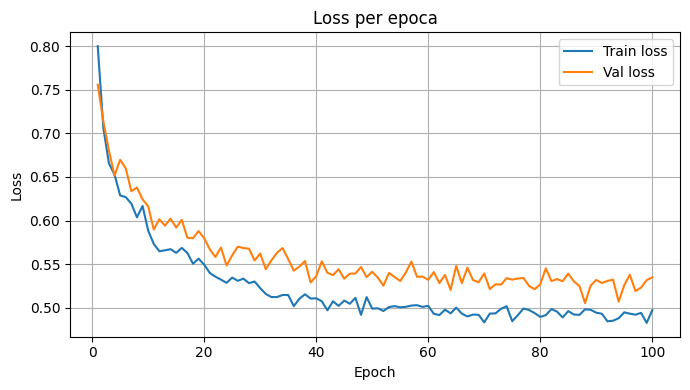

In [ ]:

epochs = np.arange(1, len(history["train_epoch_loss"]) + 1)
plt.figure(figsize=(7,4))
plt.plot(epochs, history["train_epoch_loss"], label="Train loss")
plt.plot(epochs, history["val_loss"], label="Val loss")
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.title("Loss per epoca")
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()


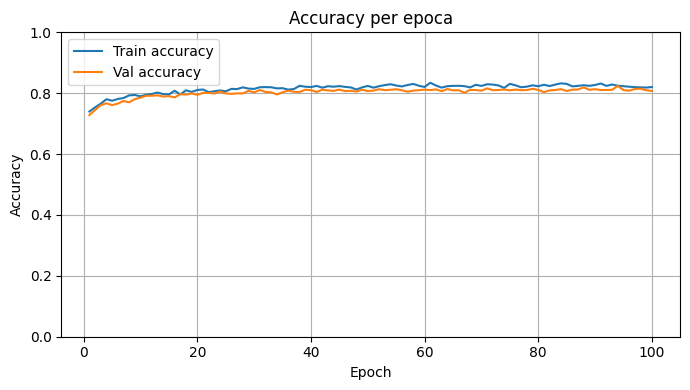

In [ ]:
plt.figure(figsize=(7,4))
plt.plot(epochs, history["train_eval_acc"], label="Train accuracy")
plt.plot(epochs, history["val_acc"], label="Val accuracy")
plt.xlabel("Epoch")
plt.ylabel("Accuracy")
plt.ylim(0, 1)
plt.title("Accuracy per epoca")
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()


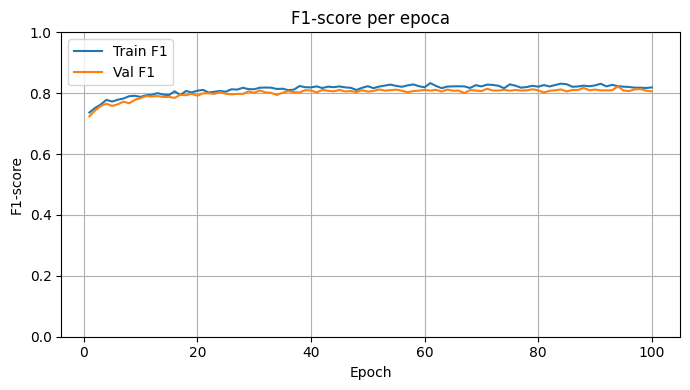

In [ ]:
plt.figure(figsize=(7,4))
plt.plot(epochs, history["train_eval_f1"], label="Train F1")
plt.plot(epochs, history["val_f1"], label="Val F1")
plt.xlabel("Epoch")
plt.ylabel("F1-score")
plt.ylim(0, 1)
plt.title("F1-score per epoca")
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()


### Protonet con Tanh + SGD

In [ ]:
model_tanh = ProtoNetHead(activation="tanh")

history_tanh = train_protonet_head(
    model_tanh,
    train_emb, train_y, idx_train,
    val_emb, val_y, idx_val,
    epochs=100,
    episodes_per_epoch=1000,
    n_way=5, n_support=5, n_query=15,
    lr=1e-2,
    weight_decay=0,
    device=device,
    seed=123,
    optimizer_name="sgd",
    momentum=0.9,
    nesterov=True,
    use_scheduler=True,
    step_size=10,
    gamma=0.5,
    eval_episodes=200,
    num_workers=0,
    log_every=100
)


[TRAIN] epoch 1/100 | step 100/1000 | loss=0.9307 | acc=0.6476 | f1=0.6417
[TRAIN] epoch 1/100 | step 200/1000 | loss=0.8835 | acc=0.6691 | f1=0.6631
[TRAIN] epoch 1/100 | step 300/1000 | loss=0.8654 | acc=0.6790 | f1=0.6735
[TRAIN] epoch 1/100 | step 400/1000 | loss=0.8493 | acc=0.6861 | f1=0.6807
[TRAIN] epoch 1/100 | step 500/1000 | loss=0.8348 | acc=0.6918 | f1=0.6868
[TRAIN] epoch 1/100 | step 600/1000 | loss=0.8180 | acc=0.6995 | f1=0.6947
[TRAIN] epoch 1/100 | step 700/1000 | loss=0.8119 | acc=0.7019 | f1=0.6974
[TRAIN] epoch 1/100 | step 800/1000 | loss=0.8054 | acc=0.7054 | f1=0.7009
[TRAIN] epoch 1/100 | step 900/1000 | loss=0.7986 | acc=0.7078 | f1=0.7034
[TRAIN] epoch 1/100 | step 1000/1000 | loss=0.7918 | acc=0.7105 | f1=0.7062
[EPOCH 1/100] train_epoch loss=0.7918 acc=0.7105 f1=0.7062 | val loss=0.7733 acc=0.7217 f1=0.7174 | lr=1.00e-02
[TRAIN] epoch 2/100 | step 100/1000 | loss=0.7378 | acc=0.7311 | f1=0.7278
[TRAIN] epoch 2/100 | step 200/1000 | loss=0.7426 | acc=0.7311

In [ ]:
train_acc_sgd_tanh = history_tanh["train_eval_acc"][-1]
val_acc_sgd_tanh   = history_tanh["val_acc"][-1]
train_f1_sgd_tanh  = history_tanh["train_eval_f1"][-1]
val_f1_sgd_tanh    = history_tanh["val_f1"][-1]

gap_sgd_tanh = abs(train_acc_sgd_tanh - val_acc_sgd_tanh) * 100

print(
    train_acc_sgd_tanh,
    val_acc_sgd_tanh,
    train_f1_sgd_tanh,
    val_f1_sgd_tanh,
    gap_sgd_tanh
)


0.8149333509802819 0.8051333531737328 0.813664295077324 0.8040829426050187 0.9799997806549055


#### Grafici

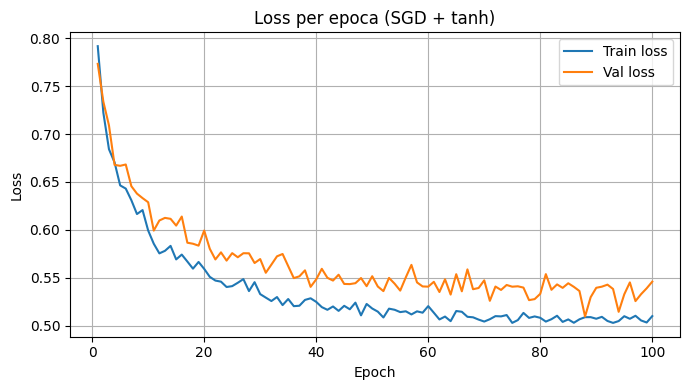

In [ ]:
epochs = np.arange(1, len(history_tanh["train_epoch_loss"]) + 1)
plt.figure(figsize=(7,4))
plt.plot(epochs, history_tanh["train_epoch_loss"], label="Train loss")
plt.plot(epochs, history_tanh["val_loss"], label="Val loss")
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.title("Loss per epoca (SGD + tanh)")
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()


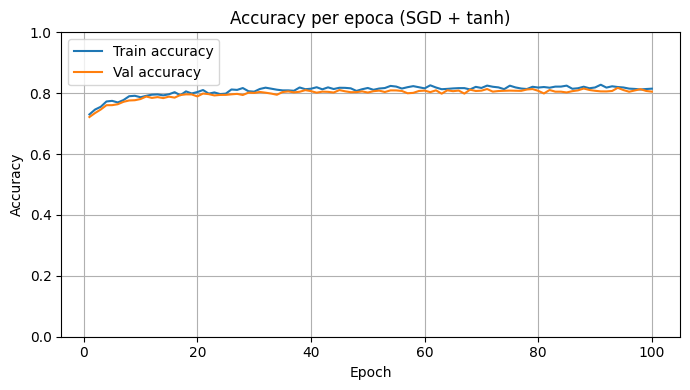

In [ ]:
plt.figure(figsize=(7,4))
plt.plot(epochs, history_tanh["train_eval_acc"], label="Train accuracy")
plt.plot(epochs, history_tanh["val_acc"], label="Val accuracy")
plt.xlabel("Epoch")
plt.ylabel("Accuracy")
plt.ylim(0, 1)
plt.title("Accuracy per epoca (SGD + tanh)")
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()


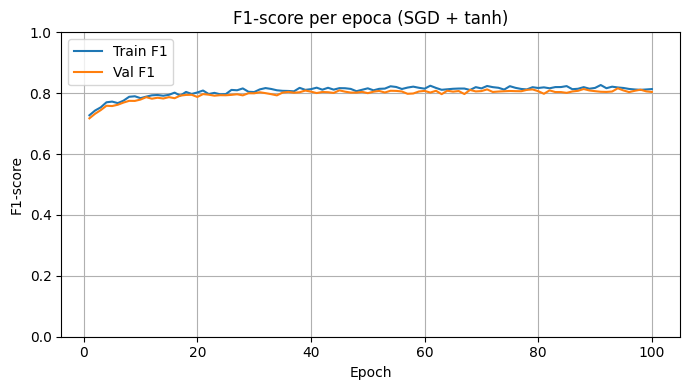

In [ ]:
plt.figure(figsize=(7,4))
plt.plot(epochs, history_tanh["train_eval_f1"], label="Train F1")
plt.plot(epochs, history_tanh["val_f1"], label="Val F1")
plt.xlabel("Epoch")
plt.ylabel("F1-score")
plt.ylim(0, 1)
plt.title("F1-score per epoca (SGD + tanh)")
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()


### Grafici Comparativi

**Confronto LOSS train**

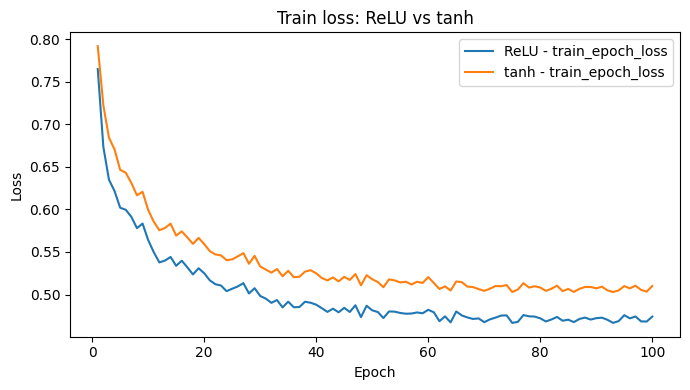

In [ ]:
plot_compare(
    history,
    history_tanh,
    key="train_epoch_loss",
    ylabel="Loss",
    title="Train loss: ReLU vs tanh"
)


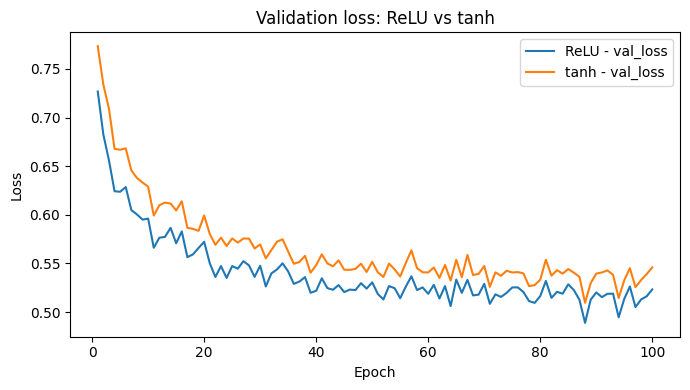

In [ ]:
plot_compare(
    history,
    history_tanh,
    key="val_loss",
    ylabel="Loss",
    title="Validation loss: ReLU vs tanh"
)


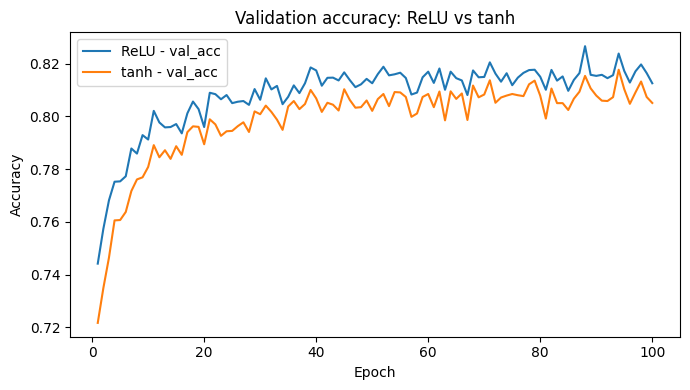

In [ ]:
plot_compare(
    history,
    history_tanh,
    key="val_acc",
    ylabel="Accuracy",
    title="Validation accuracy: ReLU vs tanh"
)


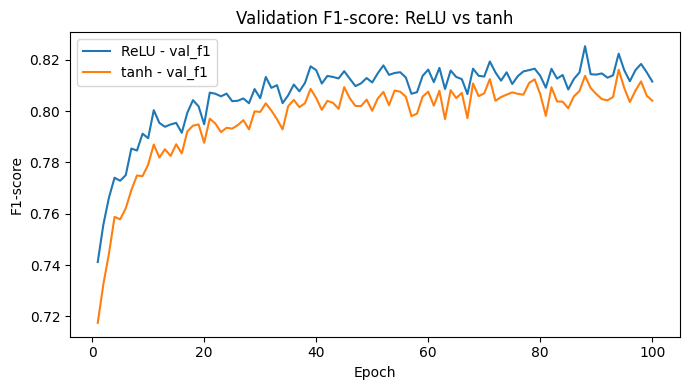

In [ ]:
plot_compare(
    history,
    history_tanh,
    key="val_f1",
    ylabel="F1-score",
    title="Validation F1-score: ReLU vs tanh"
)


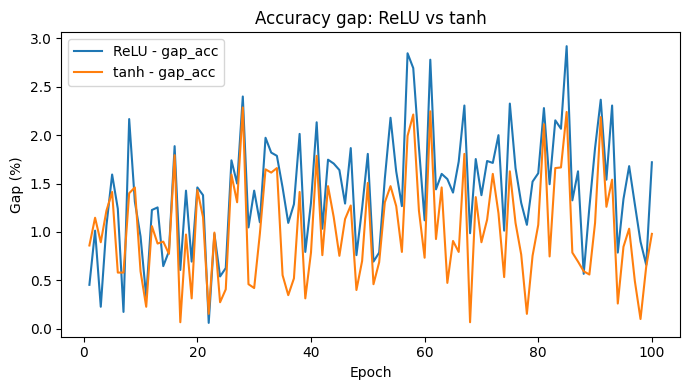

In [ ]:
history["gap_acc"] = (
    np.abs(
        np.array(history["train_eval_acc"]) -
        np.array(history["val_acc"])
    ) * 100
)

history_tanh["gap_acc"] = (
    np.abs(
        np.array(history_tanh["train_eval_acc"]) -
        np.array(history_tanh["val_acc"])
    ) * 100
)

plot_compare(
    history,
    history_tanh,
    key="gap_acc",
    ylabel="Gap (%)",
    title="Accuracy gap: ReLU vs tanh"
)


Visualizzando tutti gli esperimenti siamo arrivati alla conclusione che il modello con il maggior valore di f1 sul validation e il miglior compromesso tra validation accuracy è il modello  ProtoNet, head non lineare (tanh), distanza cosine con valori di F1 sul validation di 0.813 e di gap pari a 0.89%

# Scelta Modello Finale

Tutti i risultati finali sono stati esportati e salvati in un report PDF per garantire tracciabilità e riproducibilità.
Dal confronto delle metriche di validazione tra le diverse configurazioni, il modello con funzione di attivazione tanh ha mostrato le migliori performance complessive ed è stato pertanto selezionato come modello finale.

In [ ]:
def train_protonet_head(
    model,
    train_emb, train_y, idx_train,
    val_emb, val_y, idx_val,
    epochs=10,
    episodes_per_epoch=1000,
    n_way=5, n_support=5, n_query=15,
    lr=1e-3,
    weight_decay=0.0,
    device="cuda",
    seed=123,
    optimizer_name="adamwd",
    num_workers=0,
    eval_episodes=200,
    log_every=100,
    momentum=0.9,
    nesterov=True
    ):
    device = torch.device(device)
    model.to(device)

    if optimizer_name.lower() == "adamwd":
      optimizer = torch.optim.AdamW(model.parameters(), lr=lr, weight_decay=weight_decay)
    elif optimizer_name.lower() == "sgd":
      optimizer = torch.optim.SGD(
            model.parameters(),
            lr=lr,
            momentum=momentum,
            weight_decay=weight_decay,
            nesterov=nesterov
        )
    else:
        raise ValueError("Optimizer name must be adamw or sgd")

    history = {
        "train_epoch_loss": [],
        "train_epoch_acc": [],
        "train_epoch_f1": [],
        "train_eval_loss": [],
        "train_eval_acc": [],
        "train_eval_f1": [],
        "val_loss": [],
        "val_acc": [],
        "val_f1": [],
        "train_step_loss": [],
        "train_step_acc": [],
        "train_step_f1": [],
    }



    for epoch in range(epochs):
        model.train()
        running_losses, running_accs, running_f1s = [], [], []
        ds_train = EpisodicIterableDataset(
            train_emb, train_y, idx_train,
            n_way=n_way, n_support=n_support, n_query=n_query,
            episodes_per_epoch=episodes_per_epoch,
            seed=seed + epoch,
            device=None,
            as_torch=True
        )
        dl_train = DataLoader(ds_train, batch_size=None, num_workers=num_workers)
        for step, batch in enumerate(dl_train, start=1):
            sx = batch["support_x"].to(device)
            qx = batch["query_x"].to(device)
            sy_g = batch["support_y_g"].to(device)
            qy_g = batch["query_y_g"].to(device)
            cls_raw = batch["classes"]
            if torch.is_tensor(cls_raw):
                cls = cls_raw.to(device=device, dtype=sy_g.dtype)
            else:
                cls = torch.as_tensor(cls_raw, device=device, dtype=sy_g.dtype)

            optimizer.zero_grad(set_to_none=True)
            loss, acc, f1 = model(sx, sy_g, qx, qy_g, cls)

            if not torch.isfinite(loss):
                raise RuntimeError(f"Non-finite loss at epoch={epoch}, step={step}: {loss.item()}")

            loss.backward()
            optimizer.step()

            history["train_step_loss"].append(loss.item())
            history["train_step_acc"].append(acc.item())
            history["train_step_f1"].append(f1.item())

            running_losses.append(loss.item())
            running_accs.append(acc.item())
            running_f1s.append(f1.item())

            if log_every and (step % log_every == 0 or step == episodes_per_epoch):
                print(
                    f"[TRAIN] epoch {epoch+1}/{epochs} | step {step}/{episodes_per_epoch} "
                    f"| loss={np.mean(running_losses):.4f} | acc={np.mean(running_accs):.4f} | f1={np.mean(running_f1s):.4f}"
                )

            if step >= episodes_per_epoch:
                break

        epoch_train_loss = float(np.mean(running_losses))
        epoch_train_acc  = float(np.mean(running_accs))
        epoch_train_f1   = float(np.mean(running_f1s))

        history["train_epoch_loss"].append(epoch_train_loss)
        history["train_epoch_acc"].append(epoch_train_acc)
        history["train_epoch_f1"].append(epoch_train_f1)

        model.eval()

        train_eval_loss, train_eval_acc, train_eval_f1 = eval_head_with_loader_global(
            model, train_emb, train_y, idx_train,
            episodes=eval_episodes,
            n_way=n_way, n_support=n_support, n_query=n_query,
            device=device,
            seed=1000 + epoch,
            num_workers=num_workers,
            log_every=0,
            prefix="TRAIN-EVAL"
            )

        val_loss, val_acc, val_f1 = eval_head_with_loader_global(
            model, val_emb, val_y, idx_val,
            episodes=eval_episodes,
            n_way=n_way, n_support=n_support, n_query=n_query,
            device=device,
            seed=2000 + epoch,
            num_workers=num_workers,
            log_every=0,
            prefix="VAL"
            )

        history["train_eval_loss"].append(train_eval_loss)
        history["train_eval_acc"].append(train_eval_acc)
        history["train_eval_f1"].append(train_eval_f1)

        history["val_loss"].append(val_loss)
        history["val_acc"].append(val_acc)
        history["val_f1"].append(val_f1)

        print(
            f"[EPOCH {epoch+1}/{epochs}] "
            f"train_epoch loss={epoch_train_loss:.4f} acc={epoch_train_acc:.4f} f1={epoch_train_f1:.4f} | "
            f"train_eval loss={train_eval_loss:.4f} acc={train_eval_acc:.4f} f1={train_eval_f1:.4f} | "
            f"val loss={val_loss:.4f} acc={val_acc:.4f} f1={val_f1:.4f}"
        )

    return history


Andiamo adesso a riaddestrare il modello

In [ ]:
model_tanh = ProtoNetHead(activation="tanh")

history_tanh = train_protonet_head(
    model_tanh,
    train_emb, train_y, idx_train,
    val_emb, val_y, idx_val,
    epochs=60,
    episodes_per_epoch=1000,
    eval_episodes=200,
    n_way=5,
    n_support=5,
    n_query=15,
    lr=1e-3,
    device=device,
    log_every=100
)

[TRAIN] epoch 1/60 | step 100/1000 | loss=0.9479 | acc=0.6567 | f1=0.6511
[TRAIN] epoch 1/60 | step 200/1000 | loss=0.8954 | acc=0.6732 | f1=0.6676
[TRAIN] epoch 1/60 | step 300/1000 | loss=0.8763 | acc=0.6798 | f1=0.6742
[TRAIN] epoch 1/60 | step 400/1000 | loss=0.8599 | acc=0.6854 | f1=0.6802
[TRAIN] epoch 1/60 | step 500/1000 | loss=0.8449 | acc=0.6919 | f1=0.6870
[TRAIN] epoch 1/60 | step 600/1000 | loss=0.8281 | acc=0.6988 | f1=0.6941
[TRAIN] epoch 1/60 | step 700/1000 | loss=0.8204 | acc=0.7018 | f1=0.6973
[TRAIN] epoch 1/60 | step 800/1000 | loss=0.8119 | acc=0.7058 | f1=0.7013
[TRAIN] epoch 1/60 | step 900/1000 | loss=0.8037 | acc=0.7088 | f1=0.7044
[TRAIN] epoch 1/60 | step 1000/1000 | loss=0.7955 | acc=0.7120 | f1=0.7077
[EPOCH 1/60] train_epoch loss=0.7955 acc=0.7120 f1=0.7077 | train_eval loss=0.7250 acc=0.7367 f1=0.7343 | val loss=0.7632 acc=0.7304 f1=0.7268
[TRAIN] epoch 2/60 | step 100/1000 | loss=0.7278 | acc=0.7341 | f1=0.7313
[TRAIN] epoch 2/60 | step 200/1000 | loss=

Il modello selezionato è stato quindi riaddestrato sull’intero set di training al fine di sfruttare tutte le informazioni disponibili e ottenere la configurazione finale definitiva.

In [ ]:
test_loss, test_acc, test_f1 = eval_head_with_loader_global(
    model_tanh,
    test_emb, test_y, idx_test,
    episodes=5000,
    n_way=5, n_support=5, n_query=15,
    device=device,
    seed=123,
    num_workers=0,
    prefix="TEST"
)
print(f"[TEST] loss={test_loss:.4f} | acc={test_acc:.4f} | f1={test_f1:.4f}")



[TEST] loss=0.5418 | acc=0.8112 | f1=0.8098


La valutazione sul test set conferma le prestazioni osservate in fase di validazione con un F1 score pari a 0.8098.
Il risultato ci indica una buona capacità di generalizzazione del modello selezionato.


Dato che la nostra eval_head_with_loader_global non salva le etichette non ci permette di recuperare le label reali e predette, a questo punto partendo da quella struttura ne andiamo a creare un'altra che ci permetta di salvare le label

In [ ]:
@torch.no_grad()
def collect_preds_for_confusion(
    model,
    emb, y, idx_by_class,
    episodes=200,
    n_way=5, n_support=5, n_query=15,
    device="cuda",
    seed=123,
    num_workers=0,
):
    device = torch.device(device)
    model.to(device)
    model.eval()

    ds = EpisodicIterableDataset(
        emb, y, idx_by_class,
        n_way=n_way, n_support=n_support, n_query=n_query,
        episodes_per_epoch=episodes,
        seed=seed,
        device=None,
        as_torch=True
    )
    dl = DataLoader(ds, batch_size=None, num_workers=num_workers)

    y_true_all = []
    y_pred_all = []

    for batch in dl:
        sx = batch["support_x"].to(device)
        qx = batch["query_x"].to(device)

        sy_g = batch["support_y_g"].to(device).long()
        qy_g = batch["query_y_g"].to(device).long()
        cls  = torch.as_tensor(batch["classes"], device=device, dtype=torch.long)

        _, _, _, preds_global = model(
            sx, sy_g, qx, qy_g, cls,
            return_preds=True
        )

        y_true_all.append(qy_g.cpu())
        y_pred_all.append(preds_global.cpu())

    y_true_all = torch.cat(y_true_all).numpy()
    y_pred_all = torch.cat(y_pred_all).numpy()

    return y_true_all, y_pred_all



Fatto questo possiamo procedere con la creazione della matrice di confusione

In [ ]:
y_true, y_pred = collect_preds_for_confusion(
    model_tanh,
    test_emb, test_y, idx_test,
    episodes=5000,
    n_way=5,
    n_support=5,
    n_query=15,
    device=device,
    seed=123,
    num_workers=0
)


from sklearn.metrics import confusion_matrix
cm = confusion_matrix(y_true, y_pred)




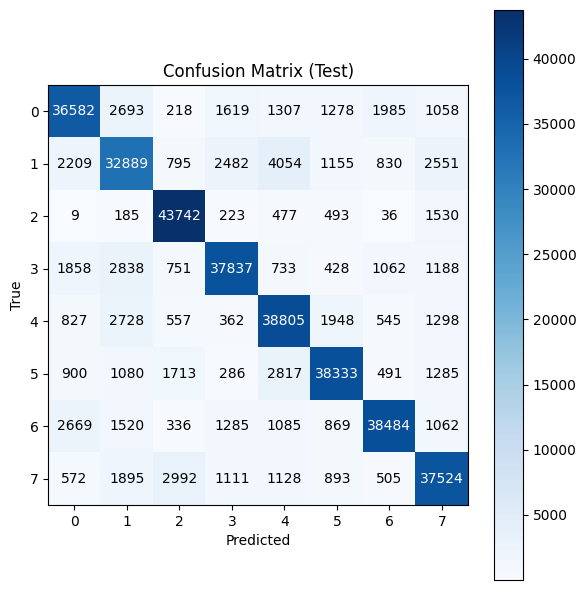

In [ ]:
plt.figure(figsize=(6, 6))
plt.imshow(cm, interpolation="nearest", cmap="Blues")
plt.title("Confusion Matrix (Test)")
plt.xlabel("Predicted")
plt.ylabel("True")
plt.colorbar()

thresh = cm.max() / 2.0
for i in range(cm.shape[0]):
    for j in range(cm.shape[1]):
        plt.text(
            j, i,
            int(cm[i, j]),
            ha="center",
            va="center",
            color="white" if cm[i, j] > thresh else "black"
        )

plt.xticks(np.arange(cm.shape[1]))
plt.yticks(np.arange(cm.shape[0]))

plt.tight_layout()
plt.show()

Oltre alla confusion matrix standard, è stata calcolata anche la confusion matrix normalizzata.
Nella versione standard vengono riportati i conteggi assoluti delle predizioni (numero di campioni per ciascuna combinazione reale/predetta), mentre nella versione normalizzata i valori sono espressi in proporzione rispetto al totale dei campioni per classe.
Questo permette di interpretare le prestazioni in termini percentuali e di confrontare meglio le classi, soprattutto in presenza di dataset sbilanciati.

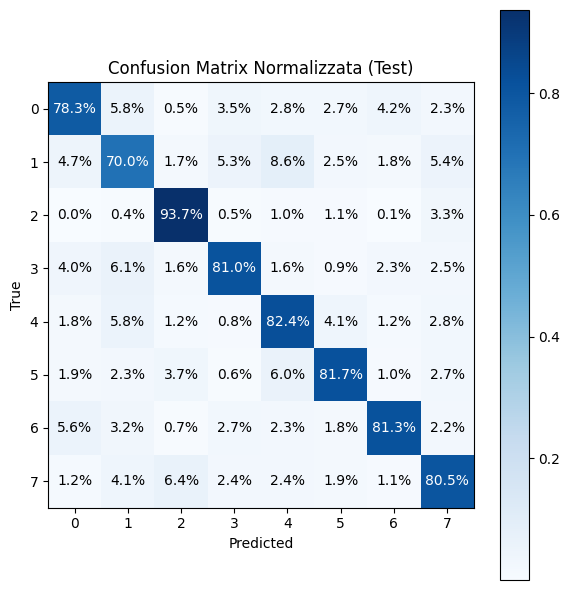

In [ ]:
cm_norm = cm / (cm.sum(axis=1, keepdims=True) + 1e-12)

plt.figure(figsize=(6, 6))
plt.imshow(cm_norm, interpolation="nearest", cmap="Blues")
plt.title("Confusion Matrix Normalizzata (Test)")
plt.xlabel("Predicted")
plt.ylabel("True")
plt.colorbar()

thresh = cm_norm.max() / 2.0
for i in range(cm_norm.shape[0]):
    for j in range(cm_norm.shape[1]):
      plt.text(
    j, i,
    f"{cm_norm[i, j]*100:.1f}%",
    ha="center",
    va="center",
    color="white" if cm_norm[i, j] > thresh else "black"
)



plt.xticks(np.arange(cm_norm.shape[1]))
plt.yticks(np.arange(cm_norm.shape[0]))

plt.tight_layout()
plt.show()
